# Welcome to the HDMM-NN Tutorial!

### Some notes of caution

Please keep in mind that this tutorial provides a platform for testing the **alpha version** of this **HDDM** extension accompanying our [paper](https://elifesciences.org/articles/65074) in which we develop likelihood approximation networks (LANs) for efficient inference of arbitrary simulation models.  We are working on improvements to enhance visualization and various other features. Please let us know on the HDDM forum and/or via github reports regarding bugs or other limitations and we will do our best to help as soon as we can.

Things to look out for at this point:
 
 - Networks were trained over a fairly wide range of parameters likely to capture the scope of common empirical data. The networks will not accurately report likelihoods outside that range, so we explicitly limit the range of parameters that can be sampled from. If you find that your posterior samples reach and get stuck at the allowed parameter bounds (which you will see in the posterior plots), please notify us and we can simply retrain the networks over a broader range of use cases over time.
 
 - Our companion paper describes two network architectures, an `MLP` and a `CNN`. You can switch from MLPs (default) to CNNs by choosing supplying ```network_type = 'cnn' ``` to the HDDMnn model classes.
 
 - The `HDDMnnRegressor` class is not yet fully robust with respect to parameter bound violations introduced through the regression backend. If you run into problem, we greatly appreciate hearing about it.

Lastly, you may encounter more print output than with standard HDDM. Please don't worry about this. Over time this verbosity will vanish, it helps us check if everything works as expected.

# SECTION 0.0: COLAB PREP

## Reminder
In the *upper left* menu click on **Runtime**, then **Change runtime type** and select **GPU** as **hardware accelerator**

### INSTALLATION COLAB: 1 MOUNT YOUR GOOGLE DRIVE


In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google.colab'

### INSTALLATION COLAB: 2 SWITCH TO TUTORIAL FOLDER

In [ ]:
%cd gdrive/'My Drive'/hddmnn_tutorial

### INSTALLATION COLAB: 3 INSTALL SUPPORT LIBRARIES

### Note 
You may get a warning about a version of `gast` package. 
Don't worry about this, it does not affect us.

In [ ]:
#!pip uninstall tensorflow  # tf 2.3.0 is loaded by default --> very slow on our networks
!pip install scikit-learn
!pip install tensorflow-gpu==1.15 # tf 1.15 ~ 4 times faster (feel free to test this out)
!pip install h5py==2.10.0
!pip install cython
!pip install pymc
#!pip install kabuki

# Note you may get a warning about a version of 'gast'. 
# Don't worry about this, it does not affect us.

### INSTALLATION COLAB: 4 INSTALL HDDM

In [ ]:
!pip install -U --no-deps git+https://github.com/hddm-devs/hddm@alex_dev
!pip install -U --no-deps git+https://github.com/hddm-devs/kabuki

# SECTION 0.1: IMPORTS (ANY SETUP)

In [1]:
# MODULE IMPORTS ----

# warning settings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# 
import hddm

# Make simulators visible
import sys
#sys.path.append('simulators')

# Data management
import pandas as pd
import numpy as np
import pickle

# Plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# Stats functionality
from statsmodels.distributions.empirical_distribution import ECDF

/Users/afengler/opt/miniconda3/envs/hddmnn_tutorial/lib/python3.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


# SECTION 1: MODEL INFO / SIMULATION / BASIC PLOTTING

The main concern of this notebook is to present the extended capabilities of the HDDM toolbox as a result of the new `HDDMnn` classes.

Primarily we are interested in the additional models we can now be fit to data. So let's take stock of the models that were added to standard **HDDM**.

### ANGLE

A model with a linearly collapsing angle. Adds a parameter $\theta$, which specifies the angle of the bound.

### WEIBULL

A model that includes a collapsing bound parameterized as the scaled *cdf* of a Weibull distribution.
This adds two parameters to the standard **DDM**, $\alpha$ and $\beta$.

### FAST FULL DDM

This is a faster version of the standard **FULL DDM**. Not a new model per se, but bypassing numerical integration for likelihood evaluations it achieves significant speed-up relatively to the basic **HDDM** version.

### LEVY

The Levy model is essentially a standard **DDM** where noise is not driven by a Gaussian distribution, but the noise process is now parameterized by the new parameter $\alpha$, which interpolates between a Gausian $\alpha = 2$ and a Cauchy (heavy tailed) $\alpha = 1$.

### ORNSTEIN

This model implements the 2-choice **LCA**, which includes a an inhibition / excitation parameter $g$. 

Find more details on these models in our companion paper. 

This section provides you *boiler-plate code* to simulate the respective models, and introduces some of the plots we provide which you may find useful. First, let's define some metadata which you can then change according to the model you want to investigate.

### Note

You can **skip** this part if you just want to see how to fit these models to data.

### 1.1 ACCESS METADATA

Let's first take a look at some of the useful metadata we can use to set up our models and simulators. 
If we type ```hddm.simulators.model_config```, we get back a dictionary that stores a bunch of information
for each of the models that are currently implemented in HDDM. It lists the parameter names under ```params```,
the parameter bounds that where used for training the networks (if you model fits reach those bounds, you should probably not trust your fit) under ```param_bounds``` (MLP) and ```param_bounds_cnn``` (CNN),
the number of parameters (```n_params```), the boundary_function (```boundary```), default parameter values (```default_params```). 
Under  ```hddm_include```, it lists the parameters which we want to include when initializing our HDDM Model with one of the sequential sampling models available.

In [ ]:
# Gives a rather long printout, so commented for now
# hddm.model_config.model_config

Now taking a closer look at the ```angle``` model

In [3]:
# Metadata
model = 'angle'
n_samples = 1000

In [3]:
# Config for our current model
hddm.model_config.model_config[model]

{'params': ['v', 'a', 'z', 't', 'theta'],
 'params_trans': [0, 0, 1, 0, 0],
 'params_std_upper': [1.5, 1.0, None, 1.0, 1.0],
 'param_bounds': [[-3.0, 0.3, 0.2, 0.001, -0.1], [3.0, 2.0, 0.8, 2.0, 1.45]],
 'param_bounds_cnn': [[-2.5, 0.2, 0.1, 0.0, 0.0],
  [2.5, 2.0, 0.9, 2.0, 1.3707963267948966]],
 'boundary': <function hddm.simulators.boundary_functions.angle(t=1, theta=1)>,
 'n_params': 5,
 'default_params': [0.0, 1.0, 0.5, 0.001, 0.0],
 'hddm_include': ['z', 'theta'],
 'n_choices': 2,
 'choices': [-1, 1],
 'slice_widths': {'v': 1.5,
  'v_std': 1,
  'a': 1,
  'a_std': 1,
  'z': 0.1,
  'z_trans': 0.2,
  't': 0.01,
  't_std': 0.15,
  'theta': 0.1,
  'theta_std': 0.2}}

Let's start by generating some data from the ```angle``` model. For this you have available the ```simulators``` module, specifically we will start with the ```simulator_h_c``` function.
We can take a look at the help file.

In [5]:
#help(hddm.simulators.hddm_dataset_generators.simulator_h_c)

Help on function simulator_h_c in module hddm.simulators.hddm_dataset_generators:

simulator_h_c(n_subjects=10, n_samples_by_subject=100, model='ddm_vanilla', conditions={'c_one': ['high', 'low'], 'c_two': ['high', 'low'], 'c_three': ['high', 'medium', 'low']}, depends_on={'v': ['c_one', 'c_two']}, regression_models=['z ~ covariate_name'], regression_covariates={'covariate_name': {'type': 'categorical', 'range': (0, 4)}}, group_only_regressors=True, group_only=['z'], fixed_at_default=['t'], p_outlier=0.0, outlier_max_t=10.0)
    Flexible simulator that allows specification of models very similar to the hddm model classes.
    
    :Arguments:
        n_subjects: int <default=5>
            Number of subjects in the datasets
        n_samples_by_subject: int <default=500>
            Number of trials for each subject
        model: str <default = 'ddm_vanilla'>
            Model to sample from. For traditional hddm supported models, append '_vanilla' to the model. Omitting 'vanilla'
   

In [7]:
# test regressors only False
# add p_outliers to the generator !
data, full_parameter_dict = hddm.simulators.hddm_dataset_generators.simulator_h_c(n_subjects = 1,
                                                                                  n_samples_by_subject = n_samples,
                                                                                  model = model,
                                                                                  p_outlier = 0.00,
                                                                                  conditions = None, 
                                                                                  depends_on = None, 
                                                                                  regression_models = None,
                                                                                  regression_covariates = None,
                                                                                  group_only_regressors = False,
                                                                                  group_only = None,
                                                                                  fixed_at_default = None)

None
{'a', 'theta', 'z', 'v', 't'}


A quick look into what the simulator spits out (you can also read about it in the docs for the simulator using the ```help()``` function).  <br/><br/>
We get back a ```tuple``` of three elements: <br/><br/> A DataFrame which holds a ``rt``, a `response` and a ```subj_idx``` column. Second our parameter dictionary.
Third our parameters as a list in the correct order as expected by multiple related functions.

In [8]:
data

rt  response subj_idx        v         a         z         t  \
0    0.574734       0.0        0 -2.92928  1.888178  0.755953  0.199736   
1    0.531735       1.0        0 -2.92928  1.888178  0.755953  0.199736   
2    0.529735       0.0        0 -2.92928  1.888178  0.755953  0.199736   
3    0.752732       0.0        0 -2.92928  1.888178  0.755953  0.199736   
4    0.324736       1.0        0 -2.92928  1.888178  0.755953  0.199736   
..        ...       ...      ...      ...       ...       ...       ...   
995  0.651733       0.0        0 -2.92928  1.888178  0.755953  0.199736   
996  0.560735       1.0        0 -2.92928  1.888178  0.755953  0.199736   
997  0.618734       0.0        0 -2.92928  1.888178  0.755953  0.199736   
998  0.755732       0.0        0 -2.92928  1.888178  0.755953  0.199736   
999  0.545735       0.0        0 -2.92928  1.888178  0.755953  0.199736   

        theta  
0    1.251737  
1    1.251737  
2    1.251737  
3    1.251737  
4    1.251737  
..        ...  
995  1.251737  
996  1.251737  
997  1.251737  
998  1.251737  
999  1.251737  

[1000 rows x 8 columns]

### 1.2 First Plot 

Now that we have our simulated data, we look to visualise it.
Let's look at a couple of plots that we can use for this purpose. 

The `model_plot()` is fairly flexible, and used through the tutorial. 

As a start, it allows you to plot simulations from a model, displayed as two histograms. 

- The top histogram refers to the probability of choosing option $1$ across time.
- The bottom (upside-down) histogram refers to the probability of choosing option $-1$ (may be coded as $0$ as well) across time.

The plot has many *style parameters* that you can set as well. Use ```help(hddm.plotting.model_plot)``` if you want to learn more.

<Figure size 640x480 with 0 Axes>

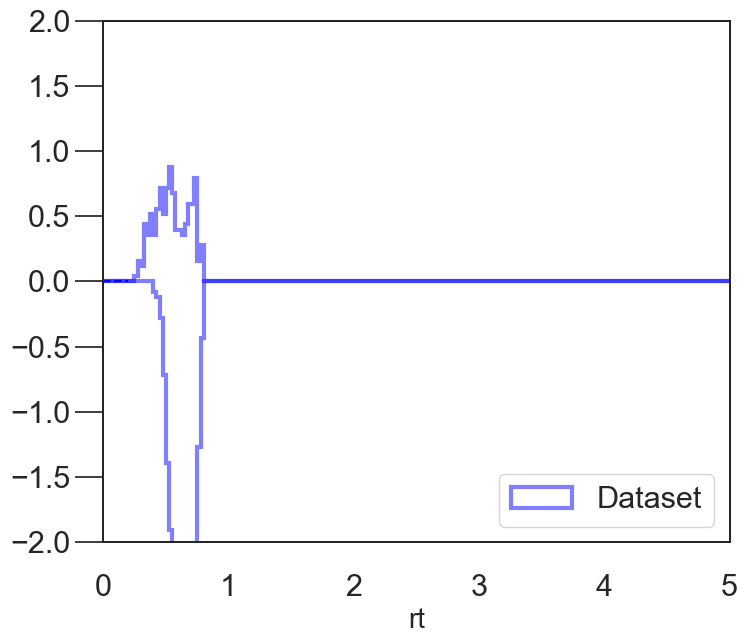

In [11]:
hddm.plotting.model_plot(dataset = data,
                         model_ground_truth = model,
                         cols = 1,
                         show_model = False,
                         scale_x = 0.4,
                         scale_y = 0.4)

If we set `show_model = True`, the `hddm.plotting.model_plot()` function will add a visualization of the ground truth model on top of the histograms. 

We will see later, that we can use this functionality to also add posterior predictives, as well as model visualizations in accordance with posterior samples.

### Note

This functionality is not yet implemented for all models.
The basic `hddm.plotting.posterior_predictive()` function can on the other hand be used for all models.

Moreover, often useful for illustration purposes, we can include a bunch of simulations trajectories into the model plot (note the corresponding arguments). Common to all models currently included is their conceptual reliance on there particle trajectories. Reaction times and choices are simulated as *boundary crossings* of these particles. If you don't want to include these trajectories, just set `show_trajectories = False`.

<Figure size 640x480 with 0 Axes>

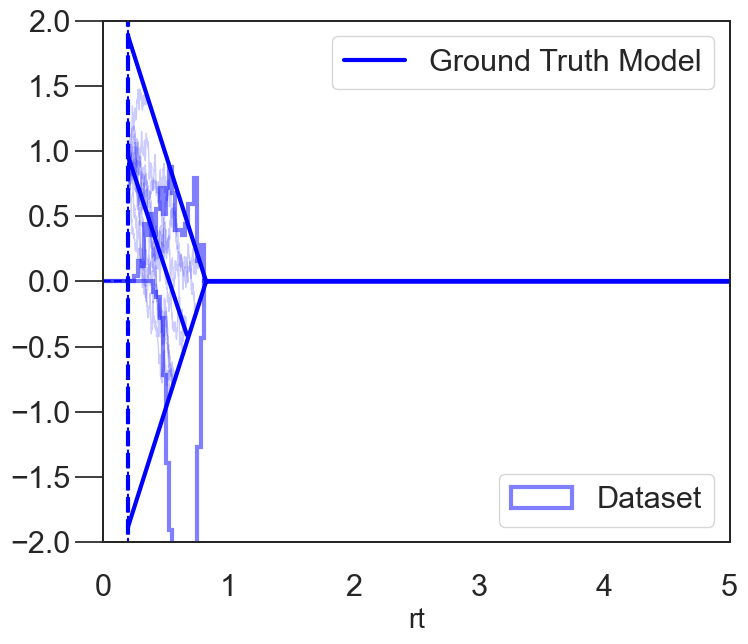

In [13]:
# Model Plots (Only data)
hddm.plotting.model_plot(dataset = data,
                       model_ground_truth = model,
                       show_trajectories = True,
                       n_trajectories = 10,
                       cols = 1,
                       show_model = True,
                       scale_x = 0.4,
                       scale_y = 0.4)

### 1.3 Varying Parameters

We can use the `model_plot()` function to understand how the model behaves across different parameterizations. 
In general you can customize the supplied datasets, but here, for simplicity, we will just use the `hddm.simulators.hddm_dataset_generators.simulator_h_c()` function again and simply set the number `n_subjects = 9`. This will generate a dataset with `9` subjects, each subject's data is generated from different parameters.

In [14]:
# test regressors only False
# add p_outliers to the generator !
data, full_parameter_dict = hddm.simulators.hddm_dataset_generators.simulator_h_c(n_subjects = 9,
                                                                                  n_samples_by_subject = n_samples,
                                                                                  model = model,
                                                                                  p_outlier = 0.00,
                                                                                  conditions = None, #{'c_one': ['low', 'high']}, #, 'c_three': ['low', 'medium', 'high']},
                                                                                  depends_on = None, #{'v': ['c_one']}, # 'theta': ['c_two']}, # 'theta': ['c_two']},
                                                                                  regression_models = None,
                                                                                  regression_covariates = None, 
                                                                                  group_only_regressors = False,
                                                                                  group_only = None,
                                                                                  fixed_at_default = None)

None
{'a', 'theta', 'z', 'v', 't'}


In [15]:
# Parameter dictionary (matches parameter names generated by HDDM)
full_parameter_dict

{'a': 0.669011387309475,
 'a_std': 0.15890788001637907,
 'theta': 0.02337978584221631,
 'theta_std': 0.0316440650724,
 'z': 0.3295184789906681,
 'z_std': 0.0015593456085666538,
 'v': 0.09065811769102039,
 'v_std': 0.35188369980002404,
 't': 1.8145578495794792,
 't_std': 0.006036829583515922,
 'a_subj.0': 0.5979573988449914,
 'theta_subj.0': 0.03720474302470596,
 'z_subj.0': 0.3292039135282875,
 'v_subj.0': -0.009544138577259678,
 't_subj.0': 1.807263261184066,
 'a_subj.1': 0.9040309754653835,
 'theta_subj.1': -0.0036404933525075317,
 'z_subj.1': 0.3318303153008138,
 'v_subj.1': -0.38294552175820157,
 't_subj.1': 1.8161834437143385,
 'a_subj.2': 0.5490747853417565,
 'theta_subj.2': 0.02151284200373594,
 'z_subj.2': 0.3288041453846749,
 'v_subj.2': 0.20501339338233854,
 't_subj.2': 1.8170556240331155,
 'a_subj.3': 0.6491774078940534,
 'theta_subj.3': -0.011203205701677446,
 'z_subj.3': 0.3292564115517743,
 'v_subj.3': -0.02249102519062303,
 't_subj.3': 1.822828253567093,
 'a_subj.4': 0.8

<Figure size 640x480 with 0 Axes>

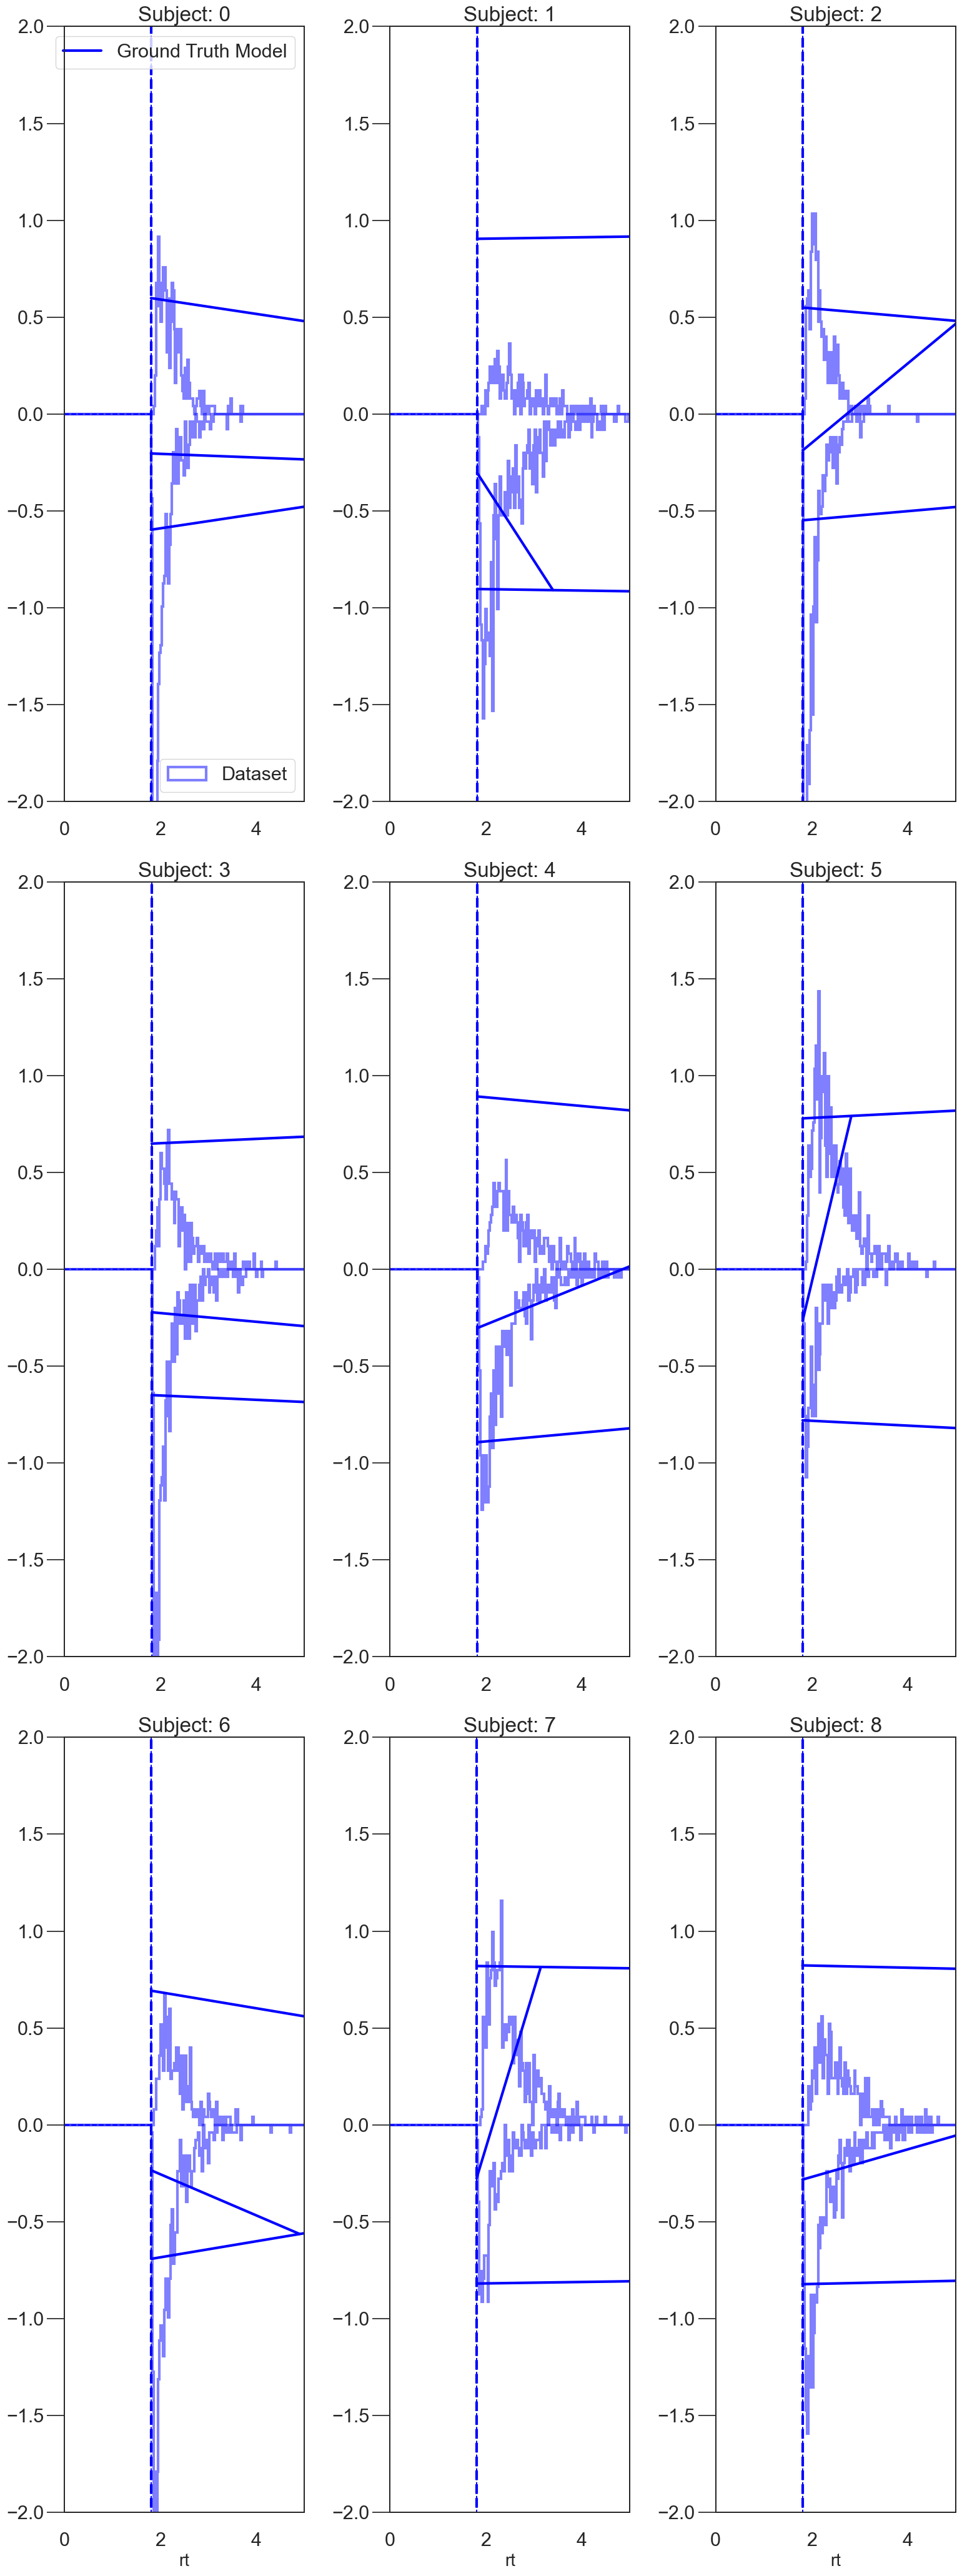

In [16]:
# Model Plots (Only data)
hddm.plotting.model_plot(dataset = data,
                       model_ground_truth = model,
                       show_trajectories = False,
                       n_trajectories = 10,
                       cols = 3,
                       show_model = True,
                       scale_x = 0.8,
                       scale_y = 0.8)

If you are interested, you can use this code to investigate the effects of the other parameters.

# SECTION 2: SINGLE SUBJECT (COLLAPSED) DATA


Now, we try to fit these models to data! Let's start with an simple dataset. In other words, we have one single participant who provides  $n$ datatpoints (reaction times and choices) from some *two alternative forced choice* task paradigm.


#### Note

In this demo we fit to simulated data. This serves as a template, and you can easily adapt it to your needs. 

In [12]:
# Metadata
nmcmc = 200
model = 'levy'
n_samples = 1000
includes = hddm.simulators.model_config[model]['hddm_include'] # Note, this makes sure you include all parameters which is not necessary ! You could also instead include fewer parameters.

In [13]:
# test regressors only False
# add p_outliers to the generator !
data, full_parameter_dict = hddm.simulators.hddm_dataset_generators.simulator_h_c(n_subjects = 5,
                                                                                  n_samples_by_subject = n_samples,
                                                                                  model = model,
                                                                                  p_outlier = 0.00,
                                                                                  conditions = None,
                                                                                  depends_on = None,
                                                                                  regression_models = None,
                                                                                  regression_covariates = None, # need this to make initial covariate matrix from which to use dmatrix (patsy)
                                                                                  group_only_regressors = False,
                                                                                  group_only = None,
                                                                                  fixed_at_default = None)

None
{'v', 'z', 'a', 't', 'alpha'}


In [14]:
data

rt  response subj_idx         v         a         z     alpha  \
0     1.094044       0.0        0 -2.256539  1.129023  0.827511  1.825053   
1     0.935046       0.0        0 -2.256539  1.129023  0.827511  1.825053   
2     1.252042       0.0        0 -2.256539  1.129023  0.827511  1.825053   
3     1.557041       0.0        0 -2.256539  1.129023  0.827511  1.825053   
4     0.672048       1.0        0 -2.256539  1.129023  0.827511  1.825053   
...        ...       ...      ...       ...       ...       ...       ...   
4995  2.301828       0.0        4 -2.052036  1.345174  0.816175  1.854041   
4996  0.909799       1.0        4 -2.052036  1.345174  0.816175  1.854041   
4997  1.468792       0.0        4 -2.052036  1.345174  0.816175  1.854041   
4998  0.969798       0.0        4 -2.052036  1.345174  0.816175  1.854041   
4999  1.946811       0.0        4 -2.052036  1.345174  0.816175  1.854041   

             t  
0     0.506048  
1     0.506048  
2     0.506048  
3     0.506048  
4     0.506048  
...        ...  
4995  0.517801  
4996  0.517801  
4997  0.517801  
4998  0.517801  
4999  0.517801  

[5000 rows x 8 columns]

In [15]:
# Define the HDDM model
hddmnn_model = hddm.HDDMnn(data,
                           informative = False,
                           include = includes,
                           p_outlier = 0.0,
                           w_outlier = 0.01,
                           model = model,
                           network_type = 'mlp')

Setting priors uninformative (LANs only work with uninformative priors for now)
printing self.nn
True
passed through flip errors nn


In [16]:
# Sample
hddmnn_model.sample(nmcmc,
                    burn = 100)

 [-----------------100%-----------------] 201 of 200 complete in 201.3 sec

In [7]:
hddmnn_model.gen_stats()

mean         std      2.5q       25q       50q       75q     97.5q  \
v      -1.14032    0.114705   -1.3527   -1.2128  -1.14184  -1.06231 -0.915442   
a      0.710689   0.0312461  0.668145  0.687141  0.704935   0.72594  0.783354   
z      0.361346   0.0117076  0.337566  0.355239  0.359958  0.371118  0.382284   
t       1.59608  0.00385273   1.58604   1.59375    1.5969   1.59867   1.60216   
theta  0.997181   0.0276429  0.951226  0.978734  0.993427   1.01327   1.05045   

            mc err  
v        0.0114705  
a       0.00312461  
z       0.00117076  
t      0.000385273  
theta   0.00276429

### 2.1 VISUALIZATION

The `caterpillar_plot()` function below displays *parameterwise*, 

-  as a <span style="color:red"> **red** </span> tick-mark the **ground truth**.
-  as a *thin* **black** line the $1 - 99$ percentile range of the posterior distribution
-  as a *thick* **black** line the $5-95$ percentile range of the posterior distribution

Again use the ```help()``` function to learn more.

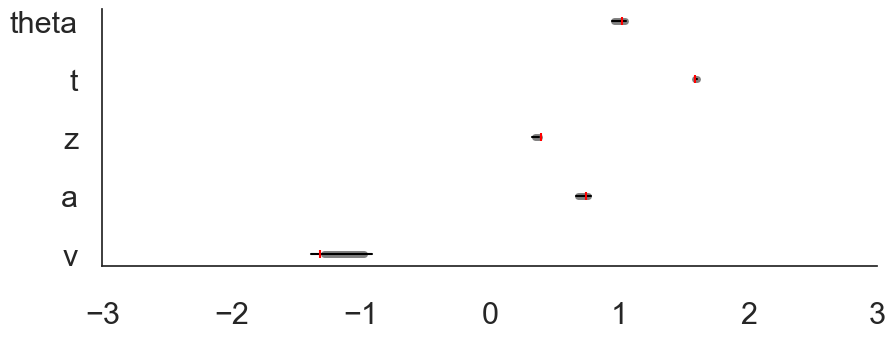

In [8]:
# Caterpillar Plot: (Parameters recovered ok?)
hddm.plotting.caterpillar_plot(hddm_model = hddmnn_model,
                             ground_truth_parameter_dict = full_parameter_dict,
                             drop_sd = False,
                             x_limits = [-3, 3])

### Posterior Predictive
Another way to examine whether or not our recovery was satisfactory is to perform posterior predictive checks. Essentially, we are looking to simulate datasets from the trace and check whether it aligns with the ground truth participant data. This answers the question of whether or not these parameters that you recovered can actually reproduce the data. Note that the parameter ``n_posterior_parameters`` controls the number of samples drawn from the trace. Here we draw randomly 200 (out of 1200).

<Figure size 640x480 with 0 Axes>

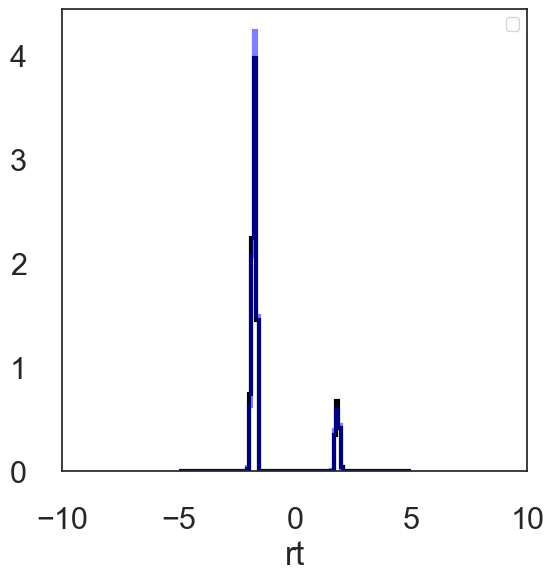

In [9]:
hddm.plotting.posterior_predictive_plot(hddm_model = hddmnn_model,
                                        model_ground_truth = model,
                                        n_posterior_parameters = 100,
                                        max_t = 5,
                                        hist_linewidth = 3,
                                        bin_size = 0.1,
                                        scale_y = 0.3,
                                        scale_x = 0.3)

<Figure size 640x480 with 0 Axes>

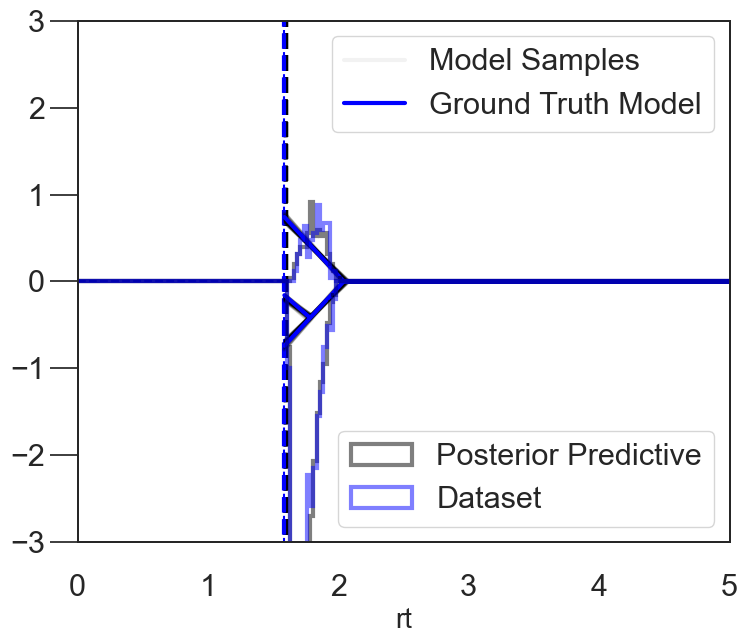

In [10]:
hddm.plotting.model_plot(hddm_model = hddmnn_model,
                       model_ground_truth = model,
                       n_posterior_parameters = 100,
                       scale_x = 0.4,
                       scale_y = 0.4,
                       ylimit = 3,
                       cols = 1)

### Note

Above we used the model plot with *empirical data* (here empirical as in our original simulator data, which we fit the model to) as opposed to specificying. Such *empirical data*, supplied under the `ground_truths_data = ...` argument is signified in <span style="color:blue"> **blue** </span>. This is in contrast to supplying a *ground truth model* under `model_ground_truth = ...`, with corresponding *ground truth parameterization* (potentially multiple for subject and / or condition separated datasets) under `ground_truths_parameters = ...`, where the `model_plot()` will simulate data for these on the fly. Empirical data doesn't have a *true* model of course, so we *don't* see a <span style="color:blue"> **blue** </span> model caricature here, but simply our posterior model parameterizations. See also **Section 8** for fitting and plotting with actual empirical data.

### A small note on convergence

Note that the MCMC algorithm requires the chain to converge. There are many heuristics that help you identifying problems with convergence, such as the trace plot, auto correlation plot, and marginal posterior histogram. In the trace plots, there might be a problem if you see large jumps. In the autocorrelation plot, there might be a problem if it does not drop rapidly. The `HDDMnn()` classes support the computation of the *Gelman-Rubin*, *r-hat* statistic, as you would with any `hddm` model. Generally, by extracting the traces, you are free to compute any convergence statistics you want of course. 

Plotting v
Plotting a
Plotting z
Plotting t
Plotting theta


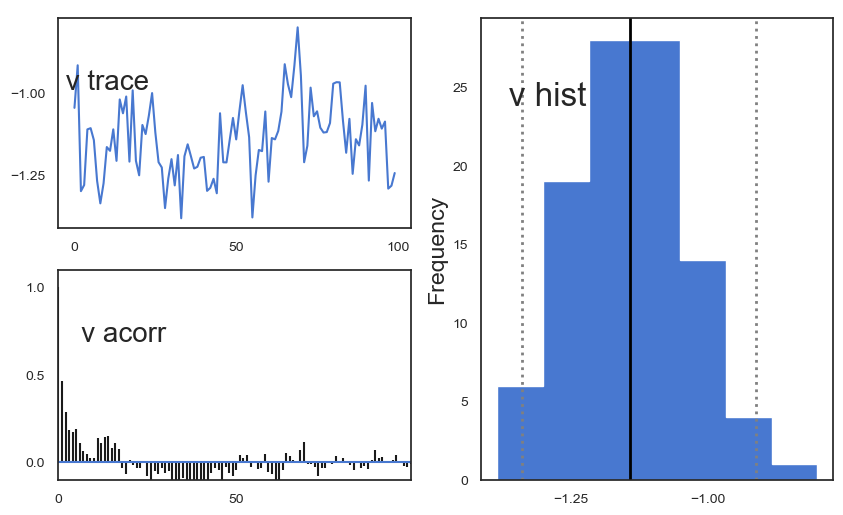

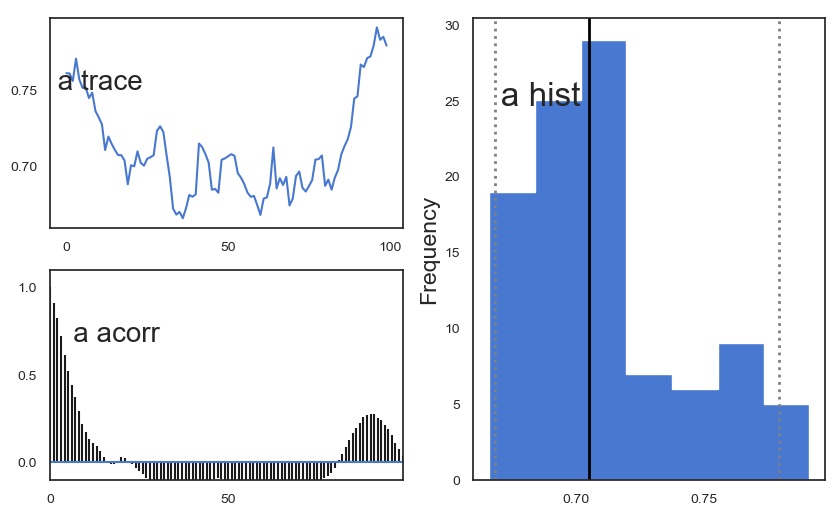

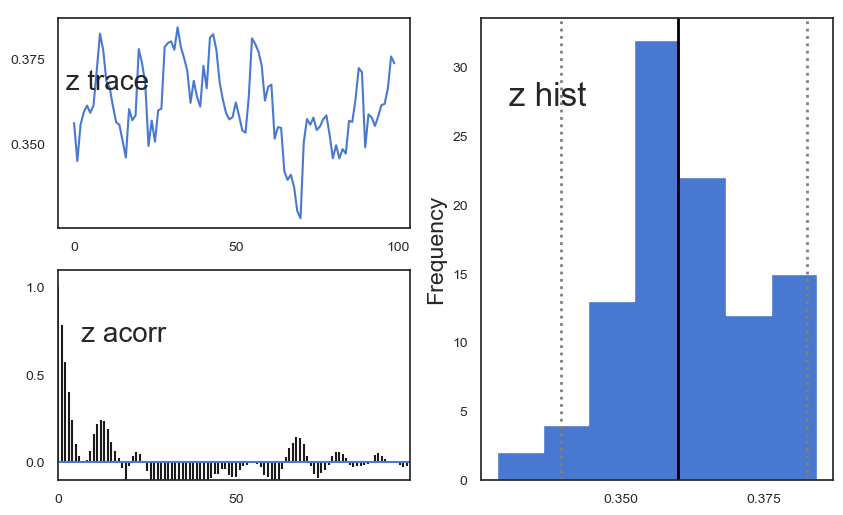

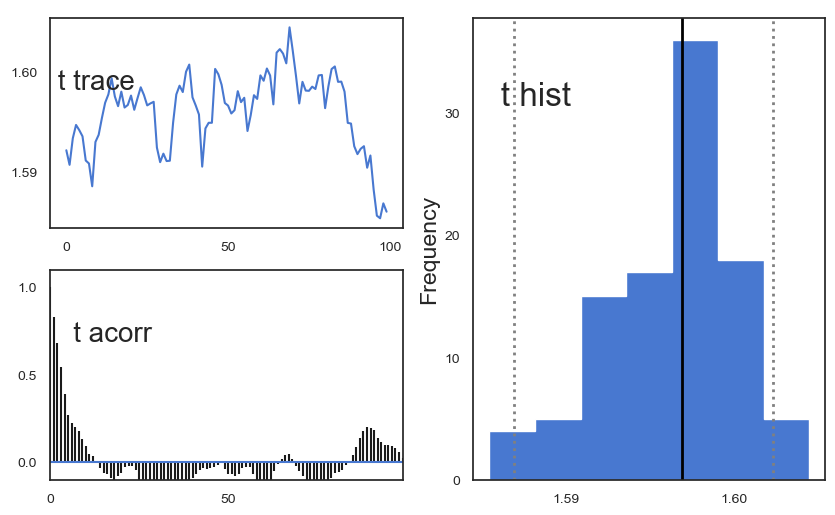

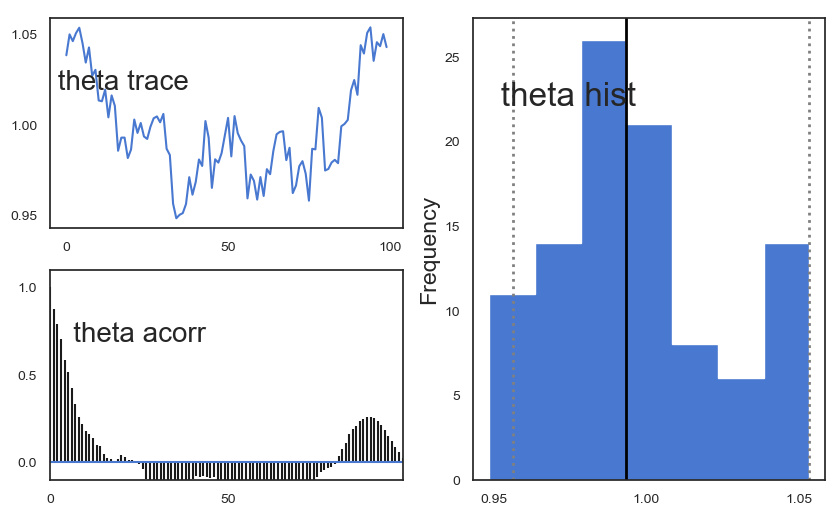

In [11]:
# TAKING A LOOK AT THE POSTERIOR TRACES
hddmnn_model.plot_posteriors(hddm.simulators.model_config[model]['params'])
plt.show()

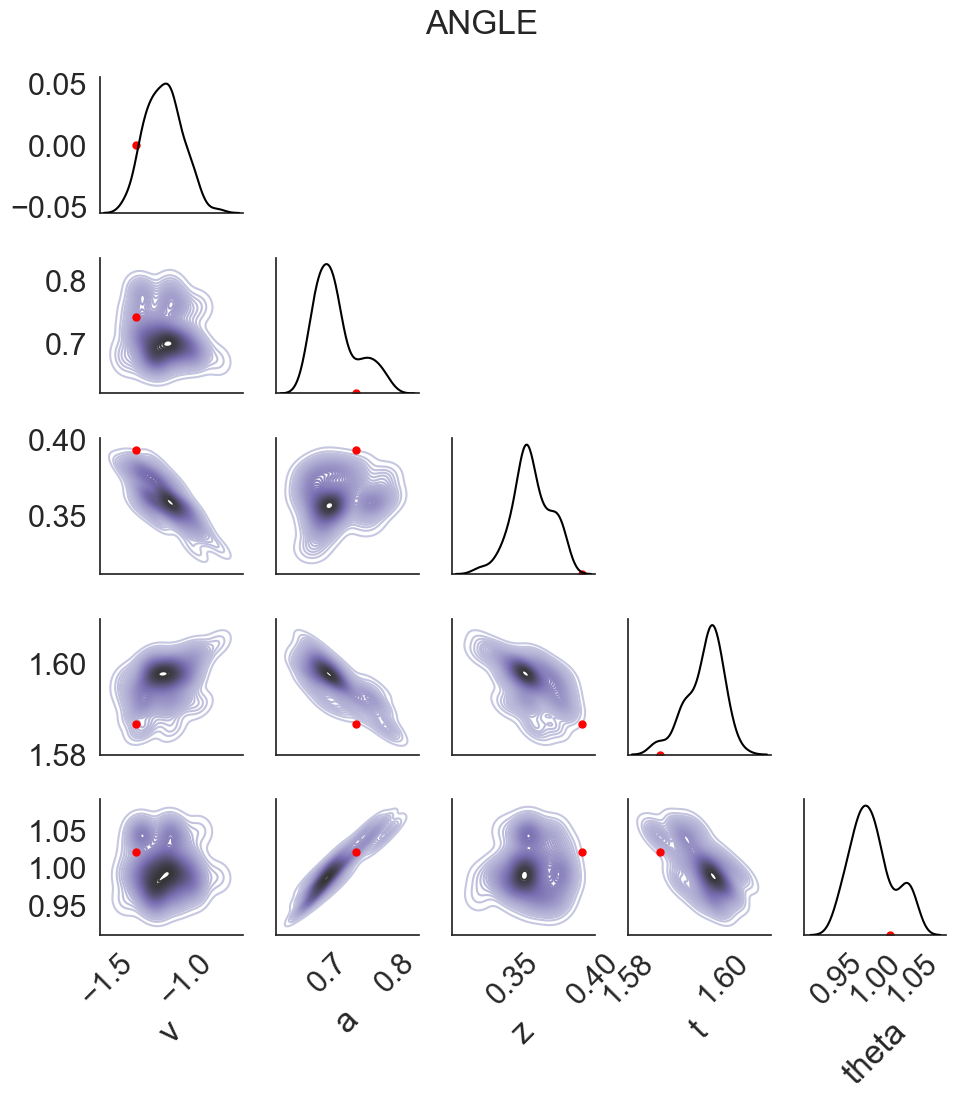

In [14]:
hddm.plotting.posterior_pair_plot(hddm_model = hddmnn_model,
                                model_ground_truth = model,
                                axes_limits = 'samples',
                                height = 2,
                                aspect_ratio = 1,
                                n_subsample = 100,
                                )

Ideally we would want to simulate a dataset from scratch and fitting it. The code to do so, is commented out above. However, due to time constraints, we will sometimes load in a dataset, its ground truth parameter and its trace. Note that the ``pickle`` is a tuple of:

0. The trace
1. Ground truth parameter
2. Dataset

# SECTION 3: HIERARCHICAL MODELS

The 'h' in `hddm` stands for hierarchical, so let's do it! If we have data from multiple participants and we assume that the parameters of single participants are drawn from respective **group** or **global** distributions, we can model this explicitly in `hddm` by specifying `is_group_model = True`.

Implicitly we are fitting a model of the following kind,

$$p(\{\theta_j\}, \{\theta_g\} | \mathbf{x}) \propto \left[ \prod_j^{J} \left[ \prod_i^{N_j} p(x_i^j | \theta_j) \right] p(\theta_j | \theta_g) \right] p( \theta_g | \theta_h )$$

where (let's say for the **angle model**),

1. $\theta_j = \{v_j, a_j, z_j, t_j, \theta_j \}$, are the model parameters for **subject j**.

2. $\theta_g = \{v_g^{\mu}, a_g^{\mu}, z_g^{\mu}, t_g^{\mu}, \theta_g^{\mu}, v_g^{\sigma}, a_g^{\sigma}, z_g^{\sigma}, t_g^{\sigma}, \theta_g^{\sigma} \}$ (scary, but for completeness), are the **mean** and **variance** parameters for our group level normal distributions, and $\{ \theta_h \}$ are **fixed hyperparameters**.

3. $x_i^j = \{rt_i^j, c_i^j \}$, are the **choice and reaction time**  of **subject j** during **trial i**.

In words, the right hand side of the equation tells us that we have a **global parameter distribution** with certain **means** and **variances** for each parameter (we want to figure these means and variances out), from which the **subject level parameters** are drawn and finally **subject level datapoints** follow the likelihood distribution of our **ddm / angle / weibull / you name it** mdoels.

In [16]:
# Metadata
nmcmc = 200
model = 'angle'
n_samples_by_subject = 200
n_subjects = 5

In [17]:
# test regressors only False
# add p_outliers to the generator !
data, full_parameter_dict = hddm.simulators.hddm_dataset_generators.simulator_h_c(n_subjects = n_subjects,
                                                                                  n_samples_by_subject = n_samples_by_subject,
                                                                                  model = model,
                                                                                  p_outlier = 0.00,
                                                                                  conditions = None, 
                                                                                  depends_on = None, 
                                                                                  regression_models = None,
                                                                                  regression_covariates = None,
                                                                                  group_only_regressors = False,
                                                                                  group_only = None,
                                                                                  fixed_at_default = None)

None
{'a', 'z', 'v', 'theta', 't'}


In [18]:
data.loc[:, ['rt', 'response']]

rt  response
0    1.520052       1.0
1    1.567052       0.0
2    1.799049       0.0
3    2.057045       0.0
4    2.026046       0.0
..        ...       ...
995  1.398910       1.0
996  1.569908       0.0
997  1.562908       0.0
998  2.074902       0.0
999  1.852905       0.0

[1000 rows x 2 columns]

In [19]:
full_parameter_dict

{'a': 1.0455959970245916,
 'a_std': 0.10815264641354724,
 'z': 0.7703382707910555,
 'z_std': 0.014665263239135104,
 'v': -0.7920243916518563,
 'v_std': 0.5140167460732964,
 'theta': 0.3233934036089394,
 'theta_std': 0.003471223682940144,
 't': 1.1496766007263852,
 't_std': 0.01060600300179415,
 'a_subj.0': 1.1336801601728055,
 'z_subj.0': 0.7930986834590837,
 'v_subj.0': -1.5116425836000815,
 'theta_subj.0': 0.31986405088093645,
 't_subj.0': 1.1370537330755768,
 'a_subj.1': 1.4019253106169458,
 'z_subj.1': 0.7679005768539962,
 'v_subj.1': -0.494082111751417,
 'theta_subj.1': 0.32561790534950646,
 't_subj.1': 1.160811738691587,
 'a_subj.2': 0.9508878118539436,
 'z_subj.2': 0.7374844458789819,
 'v_subj.2': -0.2433589428707411,
 'theta_subj.2': 0.329545487176585,
 't_subj.2': 1.149533710717474,
 'a_subj.3': 1.0637435180891812,
 'z_subj.3': 0.7604425799936416,
 'v_subj.3': -1.273605515787834,
 'theta_subj.3': 0.3170910895386252,
 't_subj.3': 1.1491886800232984,
 'a_subj.4': 1.0153081087871

In [20]:
hddmnn_model = hddm.HDDMnn(data,
                           model = model,
                           informative = False,
                           is_group_model = True,
                           include = hddm.simulators.model_config[model]['hddm_include'],
                           p_outlier = 0.0)

Setting priors uninformative (LANs only work with uninformative priors for now)
printing self.nn
True
passed through flip errors nn


In [21]:
hddmnn_model.sample(nmcmc,
                    burn = 100) # if you want to save the model specify extra arguments --> dbname='traces.db', db='pickle'. # hddmnn_model.save('test_model')

 [-----------------100%-----------------] 201 of 200 complete in 205.6 sec

In [27]:
# Sample
hddmnn_model.get_traces()

0      8.967520
1     10.272322
2      6.064919
3      9.743103
4      7.535176
        ...    
95     7.640810
96     7.756621
97     7.838439
98     7.836002
99     8.196517
Name: z_subj_trans.0, Length: 100, dtype: float64

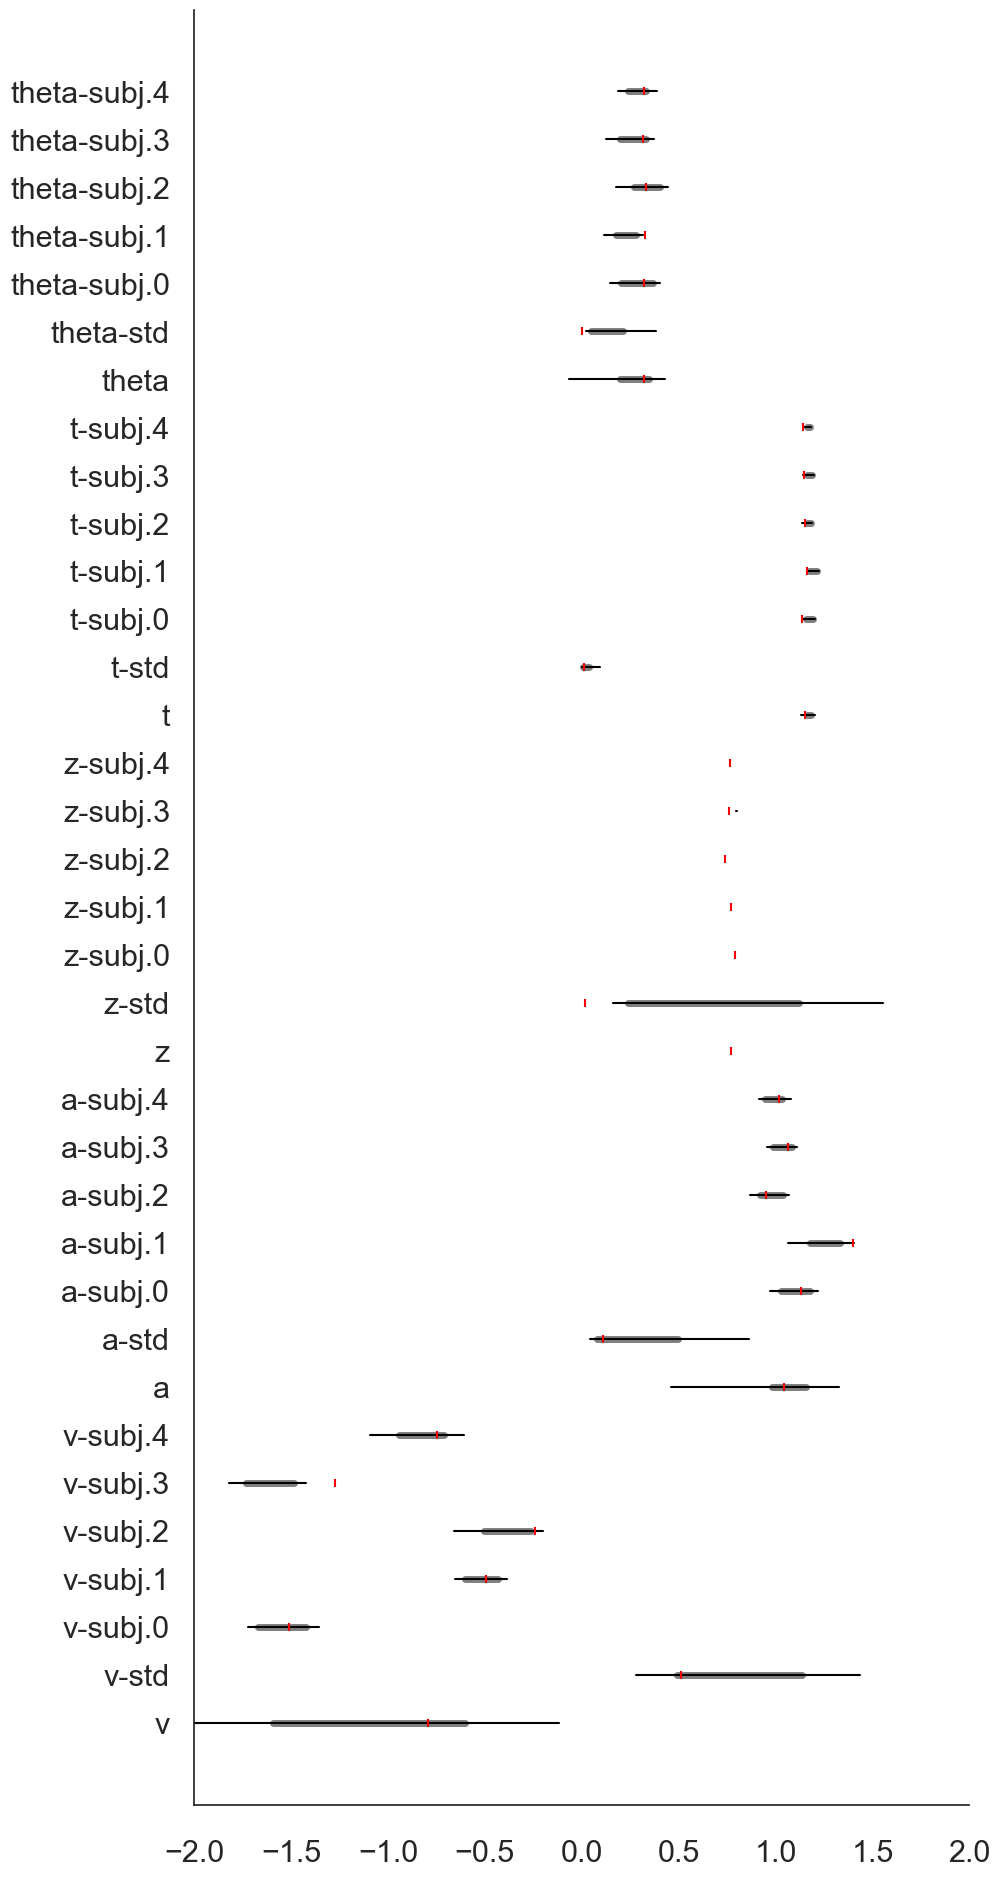

In [23]:
hddm.plotting.caterpillar_plot(hddm_model = hddmnn_model,
                               ground_truth_parameter_dict = full_parameter_dict,
                               drop_sd = False,
                               )

<Figure size 640x480 with 0 Axes>

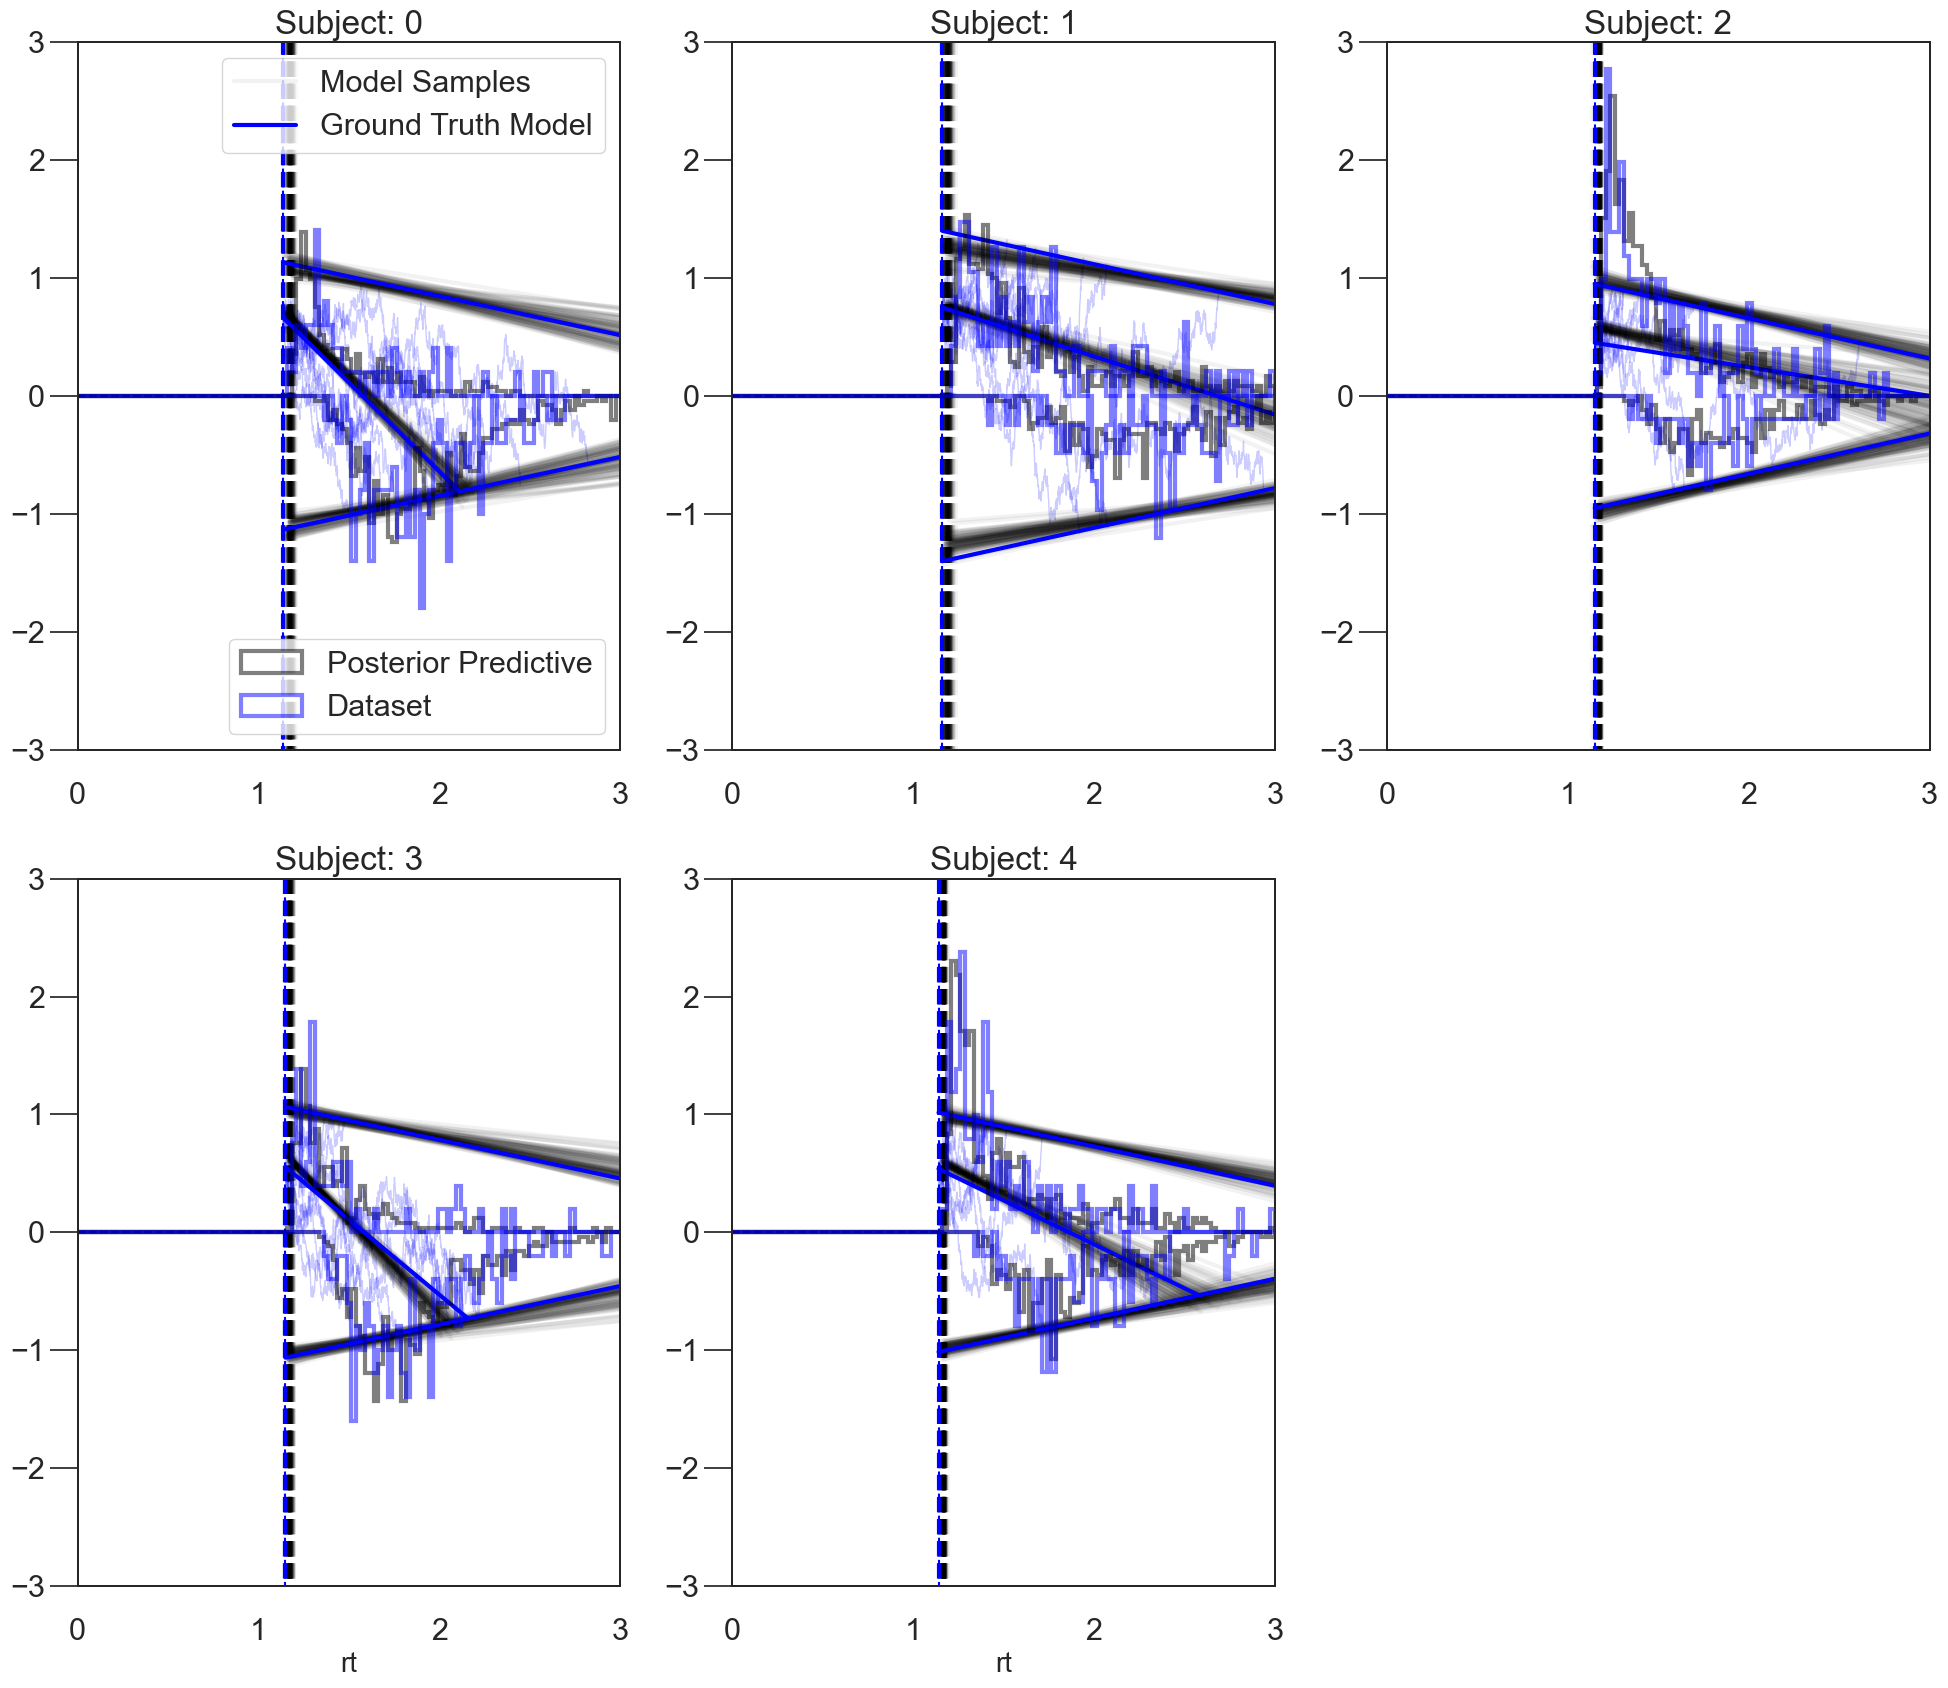

In [28]:
hddm.plotting.model_plot(hddm_model = hddmnn_model,
                       model_ground_truth= model,
                       n_posterior_parameters = 100,
                       n_simulations_per_parameter = 10,
                       show_trajectories = True,
                       cols = 3,
                       show_model = True,
                       ylimit = 3,
                       max_t = 3,
                       scale_x = 1.0,
                       scale_y = 0.5
                       )

# SECTION 4: PARAMETER VARIES BY CONDITION

An important aspect of these posterior analysis, is the consideration of experiment design.
We may have an experiment in which subject are exposed to a variety of conditions, 
such as for example different degrees of difficulty of the same task

It is often reasonable to assume that all but the conceptually relevant parameters are common across conditions.

As a by-product, such experiment designs can help us with the recovery of the constant parameters, by probing those static aspects of the model across varying kinds of datasets (driven by targeted manipulation of variable aspects of the model).

Implicitly we fit the following kind of model,

$$p( \{\theta_c \}, \theta | \mathbf{x} ) \propto  \left[ \prod_c^C  \left[ \prod_i^{N_i} p( x_i^c | \theta_c, \theta ) \right] p(\theta_c)  \right] p(\theta)$$


Where $\theta_c$ is the condition dependent part of the parameter space, and $\theta$ forms the portion of parameters which remain constant across condtions. 

To give a more concrete example involving the **weibull model** (executed below), consider a dataset for a single participant, who went through four conditions of an experiment. Think of the conditions as manipulating the payoff structure of the experiment to incentivize / disincentivize accuracy in favor of speed. We operationalize this by treating the $a$ parameter, the initial boundary separation, as affected by the manipulation, while the rest of the parameters are constant across all experiment conditions.

The resulting model would be of the form, 

$$ p( {a_c}, v, z, t, \alpha, \beta | x ) \propto \left[ \prod_c^C  \left[ \prod_i^{N_c} p( x_i^c | a_c, v, z, t, \alpha, \beta)  \right] p(a_c) \right]  p(v, z, t, \alpha, \beta)$$ 

In [29]:
# Metadata
nmcmc = 300
model = 'angle'
n_samples_by_subject = 500

In [30]:
# test regressors only False
# add p_outliers to the generator !
data, full_parameter_dict = hddm.simulators.hddm_dataset_generators.simulator_h_c(n_subjects = 1,
                                                                                  n_samples_by_subject = n_samples_by_subject,
                                                                                  model = model,
                                                                                  p_outlier = 0.00,
                                                                                  conditions = {'c_one': ['low', 'medium', 'high']},
                                                                                  depends_on = {'v': ['c_one']}, 
                                                                                  regression_models = None,
                                                                                  regression_covariates = None,
                                                                                  group_only_regressors = False,
                                                                                  group_only = None,
                                                                                  fixed_at_default = None)

None
{'theta', 't', 'a', 'z'}
Conditions created...
    c_one
0     low
1  medium
2    high
new round of data simulation because parameter bounds where violated


In [31]:
# Make HDDM Model 
hddmnn_model = hddm.HDDMnn(data, 
                           model = model,
                           informative = False,
                           include = hddm.simulators.model_config[model]['hddm_include'],
                           p_outlier = 0.0,
                           is_group_model = False, 
                           depends_on = {'v': 'c_one'})

Setting priors uninformative (LANs only work with uninformative priors for now)
printing self.nn
True
passed through flip errors nn


In [32]:
# Sample
hddmnn_model.sample(nmcmc, burn = 100)

 [-----------------100%-----------------] 301 of 300 complete in 135.8 sec

<Figure size 640x480 with 0 Axes>

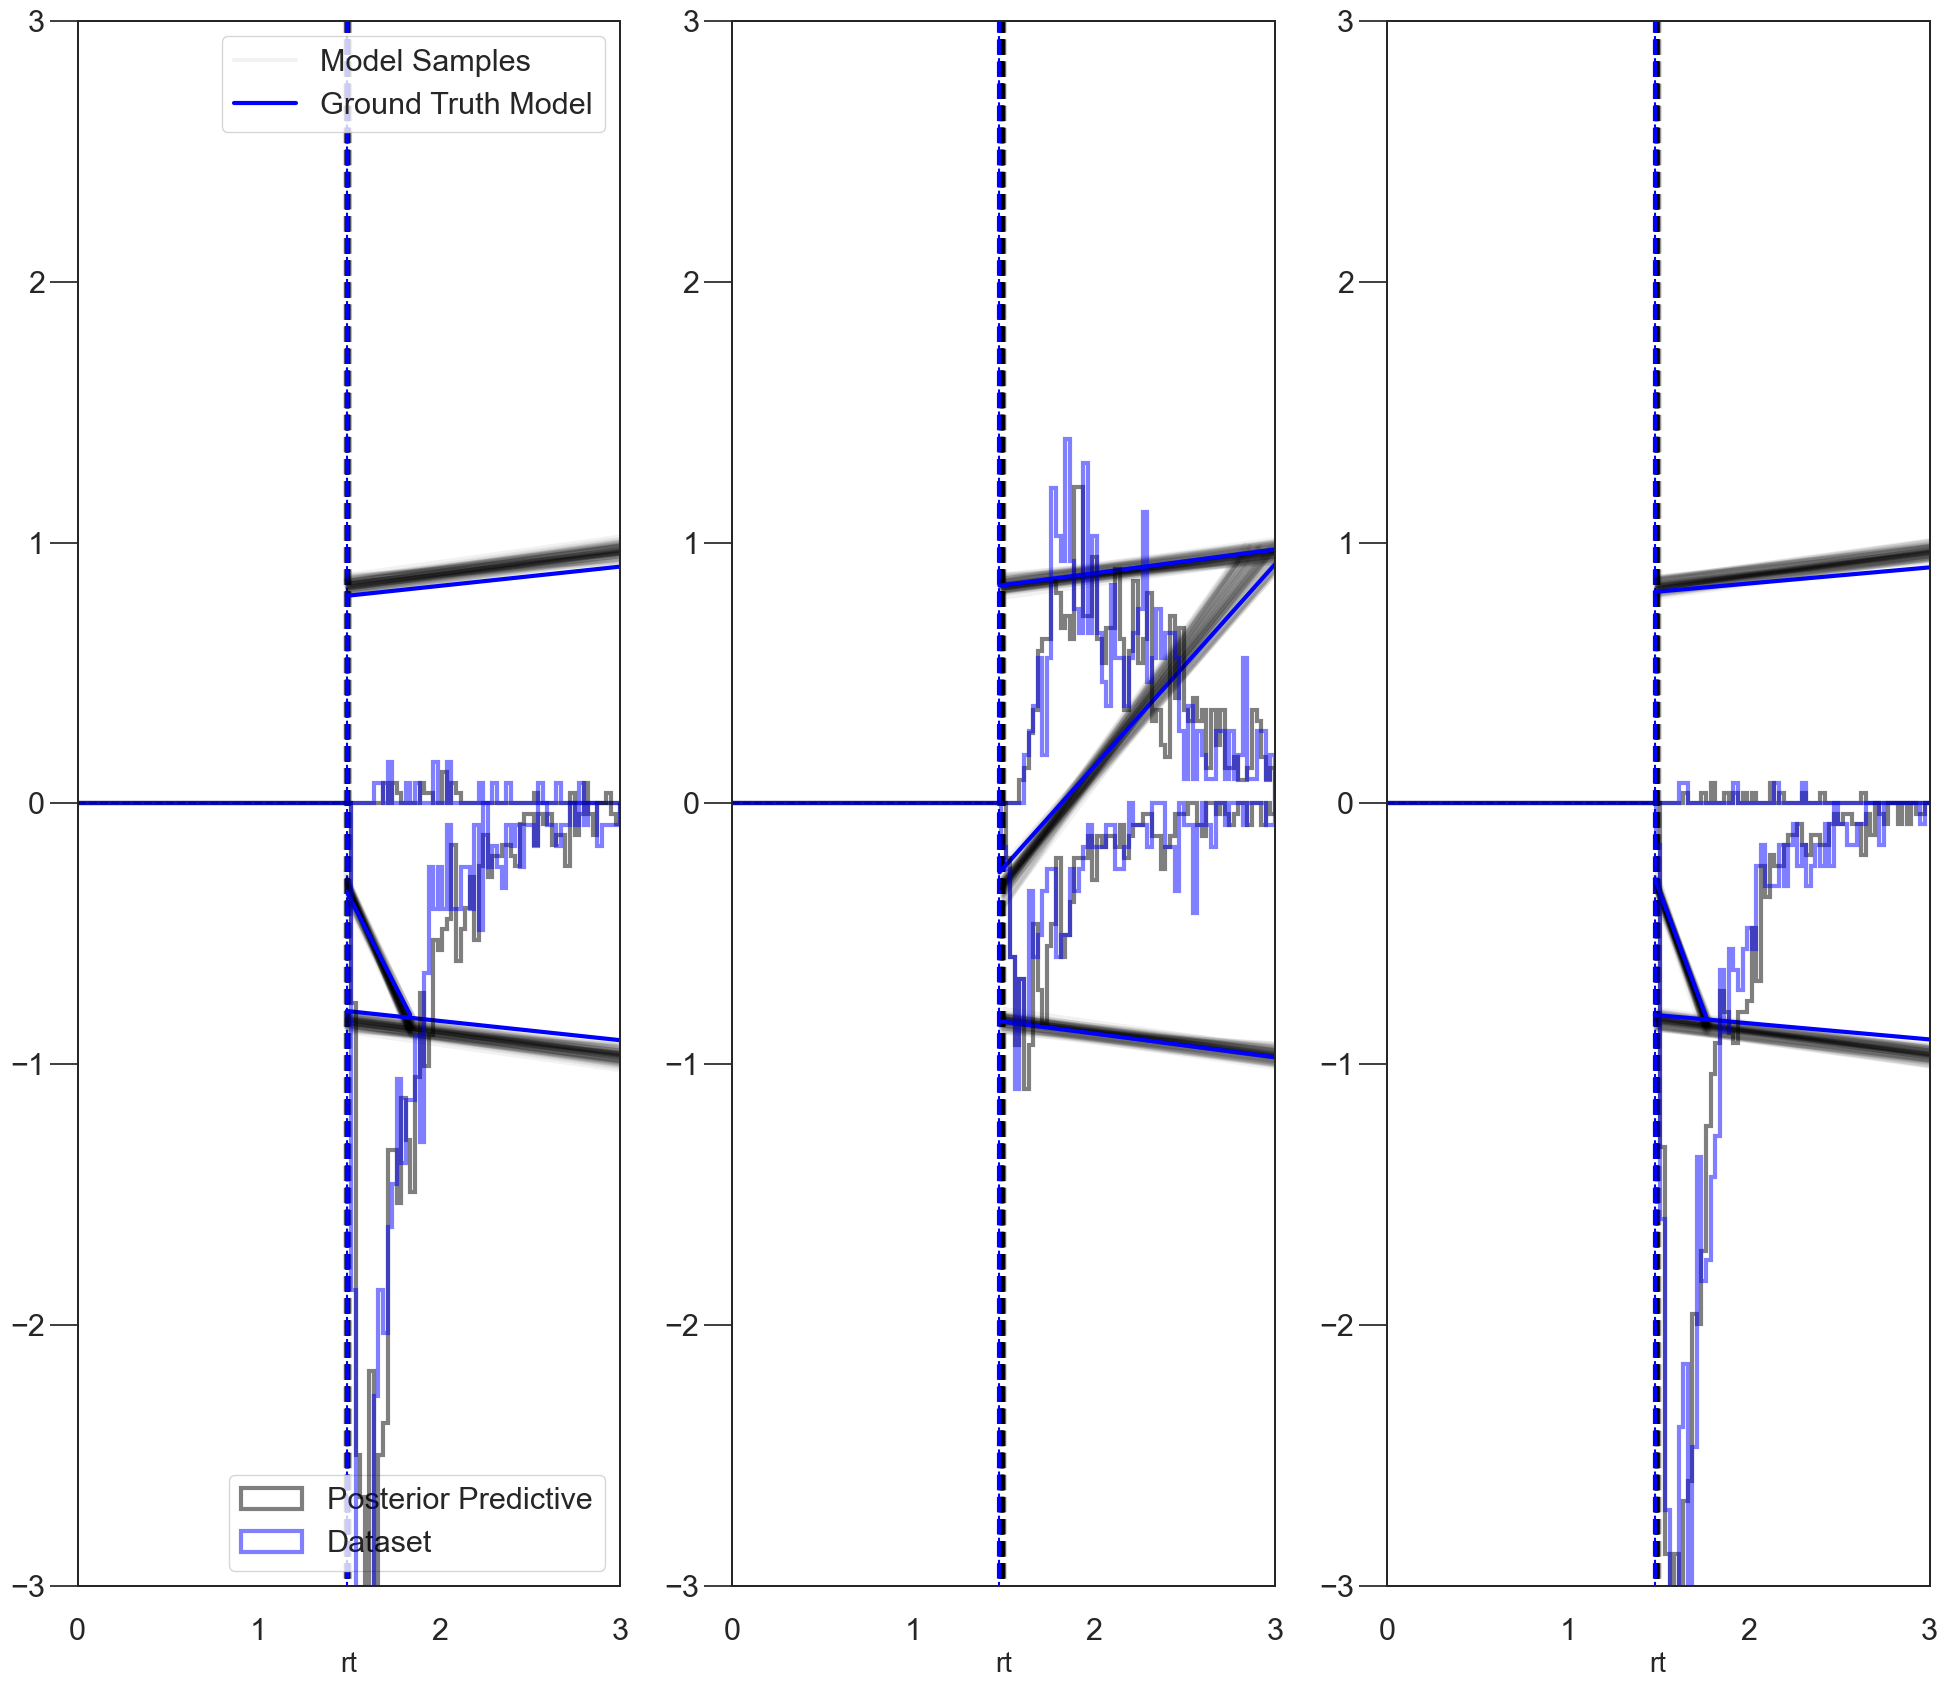

In [34]:
hddm.plotting.model_plot(hddm_model = hddmnn_model,
                       model_ground_truth= model,
                       n_posterior_parameters = 100,
                       n_simulations_per_parameter = 10,
                       show_trajectories = False,
                       cols = 3,
                       show_model = True,
                       ylimit = 3,
                       max_t = 3,
                       )

As a sidenote: You might observe that the *posterior predictive* fits the data quite well, 
but the ground truth model and posterior models do not look the same. We discuss this aspect in detail in our [paper](https://elifesciences.org/articles/65074).

## INTERMEZZO: We can of course combine Hierarchical and Condition data

In [12]:
# Metadata
nmcmc = 2000
model = 'angle'
n_subjects = 5
n_samples_by_subject = 500
#n_samples_by_condition = 500

In [5]:
# test regressors only False
# add p_outliers to the generator !
data, full_parameter_dict = hddm.simulators.hddm_dataset_generators.simulator_h_c(n_subjects = n_subjects,
                                                                                  n_samples_by_subject = n_samples_by_subject,
                                                                                  model = model,
                                                                                  p_outlier = 0.00,
                                                                                  conditions = {'c_one': ['low', 'medium', 'high']}, #, 'c_three': ['low', 'medium', 'high']},
                                                                                  depends_on = {'v': ['c_one']}, # 'theta': ['c_two']}, # 'theta': ['c_two']}, #regression_models = None, #
                                                                                  regression_models = None, #regression_covariates = None, 
                                                                                  regression_covariates = None, # need this to make initial covariate matrix from which to use dmatrix (patsy)
                                                                                  group_only_regressors = False,
                                                                                  group_only = None,
                                                                                  fixed_at_default = None)

None
{'theta', 't', 'a', 'z'}
Conditions created...
    c_one
0     low
1  medium
2    high
new round of data simulation because parameter bounds where violated


In [6]:
full_parameter_dict

{'theta': 0.07615421214827992,
 'theta_std': 0.0019495995587824875,
 't': 0.24792178756005329,
 't_std': 0.07218912404674326,
 'a': 0.7227923025539498,
 'a_std': 0.10649647994830547,
 'z': 0.47896138739310384,
 'z_std': 0.025535411775950013,
 'v(high)': 2.115331753297726,
 'v(low)': -1.462527076895352,
 'v(medium)': 2.1172833435661023,
 'v_std': 0.09134626785384949,
 'theta_subj.0': 0.07734554632957624,
 't_subj.0': 0.3000703063674009,
 'a_subj.0': 0.7558416106699372,
 'z_subj.0': 0.48935662298257404,
 'v_subj(low).0': -1.332385888110179,
 'theta_subj.1': 0.07783732538726484,
 't_subj.1': 0.3358363983200263,
 'a_subj.1': 0.5410714650552568,
 'z_subj.1': 0.4603358647342398,
 'v_subj(low).1': -1.446611488584237,
 'theta_subj.2': 0.07226729034587034,
 't_subj.2': 0.2679393335407934,
 'a_subj.2': 0.6734792214484903,
 'z_subj.2': 0.4650444376242587,
 'v_subj(low).2': -1.4458958480248012,
 'theta_subj.3': 0.07376918982172068,
 't_subj.3': 0.2714068608644944,
 'a_subj.3': 0.6261897492664873,


In [7]:
# Make HDDM Model 
hddmnn_model = hddm.HDDMnn(data,
                           model = model,
                           informative = False,
                           include = hddm.simulators.model_config[model]['hddm_include'],
                           p_outlier = 0.0,
                           is_group_model = True,
                           depends_on = {'v': 'c_one'})

Setting priors uninformative (LANs only work with uninformative priors for now)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
printing self.nn
True
passed through flip errors nn


In [13]:
hddmnn_model.sample(nmcmc, burn = 100)

 [-----------------100%-----------------] 2001 of 2000 complete in 3772.4 sec

In [14]:
hddmnn_model.get_traces()

v(high)    v(low)  v(medium)     v_std  v_subj(high).0  v_subj(high).1  \
0     2.066456 -1.278774   2.794163  0.449419        2.167305        2.268994   
1     2.013005 -1.333247   2.432925  0.535735        2.278990        2.176549   
2     1.862295 -1.368089   2.677498  0.465473        2.343975        2.166392   
3     2.108473 -1.059366   2.777945  0.479169        2.381228        2.089842   
4     2.294867 -1.390512   2.636298  0.675487        2.396336        2.031101   
...        ...       ...        ...       ...             ...             ...   
1895  2.145799 -1.262587   2.571043  0.474980        2.329358        2.146687   
1896  2.327240 -1.362850   2.288209  0.389365        2.361655        1.975519   
1897  2.064289 -1.207770   2.427106  0.462310        2.553680        2.276541   
1898  2.189744 -1.230484   2.464710  0.382060        2.288523        2.140945   
1899  1.922396 -1.286714   2.311470  0.564391        2.161217        2.206487   

      v_subj(high).2  v_subj(high).3  v_subj(high).4  v_subj(low).0  ...  \
0           2.000849        2.993267        1.168808      -1.202931  ...   
1           2.017863        2.815312        1.094053      -1.248566  ...   
2           1.984476        2.749759        1.126025      -1.249414  ...   
3           2.072396        2.788736        1.212716      -1.299056  ...   
4           2.024952        2.953096        1.221787      -1.203035  ...   
...              ...             ...             ...            ...  ...   
1895        2.013302        2.836228        1.205423      -1.217730  ...   
1896        2.002596        2.831536        1.184098      -1.167544  ...   
1897        1.973244        2.880488        1.156769      -1.208937  ...   
1898        1.841594        2.828921        1.195023      -1.262147  ...   
1899        2.018205        2.974375        1.198131      -1.195068  ...   

      t_subj.2  t_subj.3  t_subj.4     theta  theta_std  theta_subj.0  \
0     0.205954  0.278801  0.159787  0.078236   0.457417     -0.038522   
1     0.202756  0.272453  0.169103 -0.081475   0.296391     -0.069119   
2     0.205427  0.280425  0.174724 -0.077877   0.304765     -0.096233   
3     0.206872  0.277799  0.167606  0.143676   0.283973     -0.097238   
4     0.211613  0.275748  0.173115  0.239285   0.986524     -0.042918   
...        ...       ...       ...       ...        ...           ...   
1895  0.220140  0.270564  0.154458 -0.058571   0.288157     -0.095206   
1896  0.216926  0.272956  0.159903  0.086337   0.290729     -0.071873   
1897  0.222843  0.275958  0.162011  0.047200   0.163696     -0.081764   
1898  0.217783  0.276825  0.156506  0.150217   0.555106     -0.063557   
1899  0.217182  0.272266  0.155937  0.447627   0.423735     -0.087773   

      theta_subj.1  theta_subj.2  theta_subj.3  theta_subj.4  
0         0.117616      0.050312     -0.099038      0.451735  
1         0.143931      0.067926     -0.091667      0.453111  
2         0.127442      0.061937     -0.093295      0.435385  
3         0.072894      0.052634     -0.097183      0.452430  
4         0.116416      0.062376     -0.098054      0.427585  
...            ...           ...           ...           ...  
1895      0.087866     -0.016992     -0.098835      0.463983  
1896      0.088371     -0.015100     -0.098232      0.471978  
1897      0.053702      0.037927     -0.098031      0.461496  
1898      0.074242      0.026416     -0.055913      0.480914  
1899      0.002718      0.049031     -0.070404      0.483309  

[1900 rows x 47 columns]

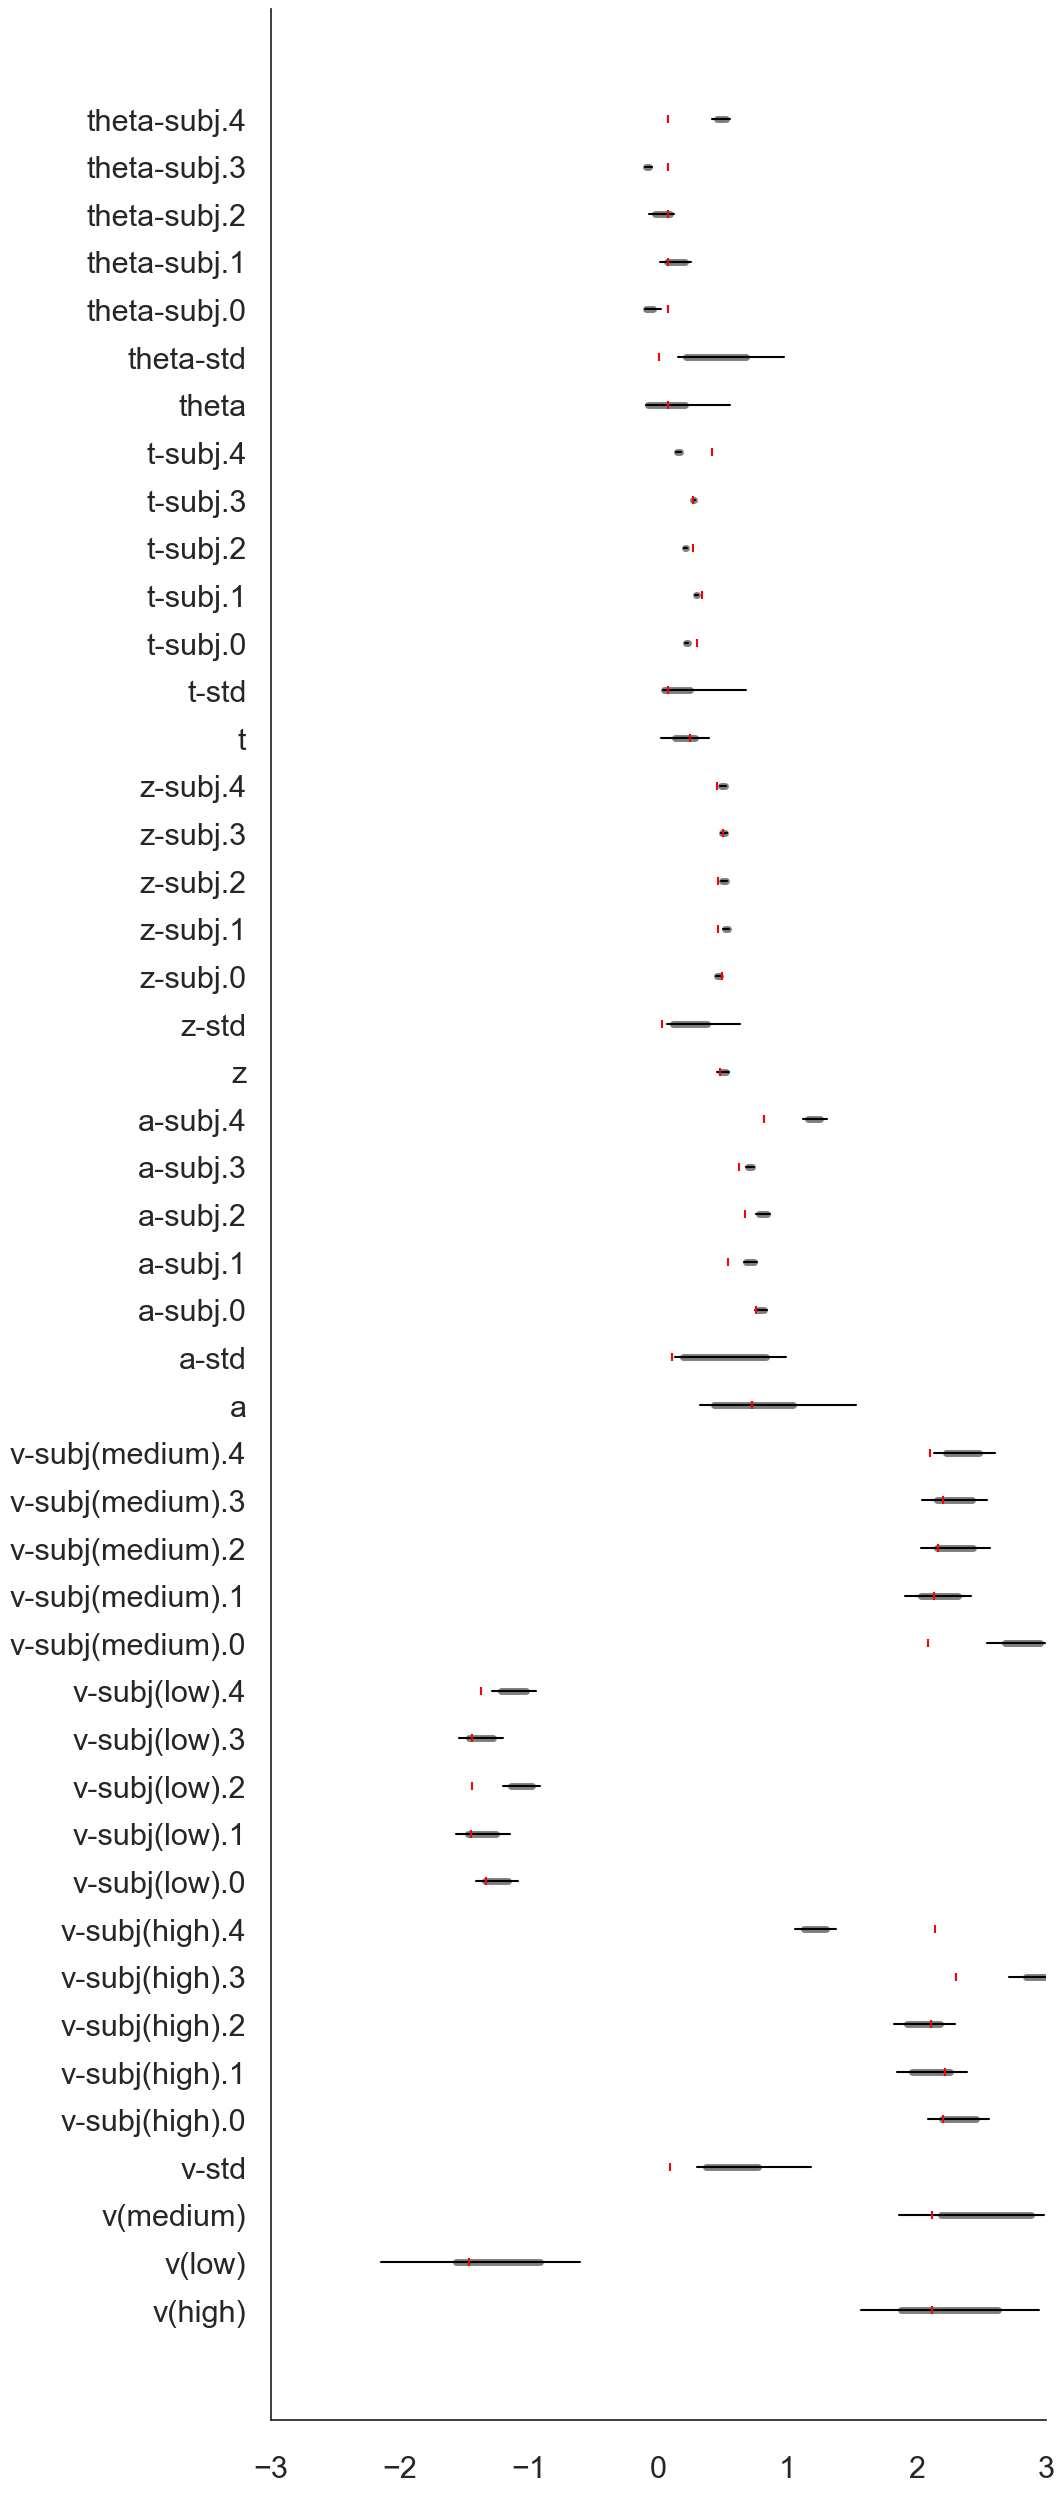

In [15]:
hddm.plotting.caterpillar_plot(hddm_model = hddmnn_model,
                               ground_truth_parameter_dict = full_parameter_dict,
                               drop_sd = False,
                               x_limits = (-3, 3))

### NOTE ON PLOTTING WITH THE MODEL PLOT

You can now plot the resulting data in two ways, by changing the ```group_by``` argument to the model plot. 

If you supply ```groupby = True```, you will get *one plot per condition* which provides you with a group level posterior.

If you set ```group_by=False```, you get a figure for each condition, with subplots corresponding to single subjects.

<Figure size 640x480 with 0 Axes>

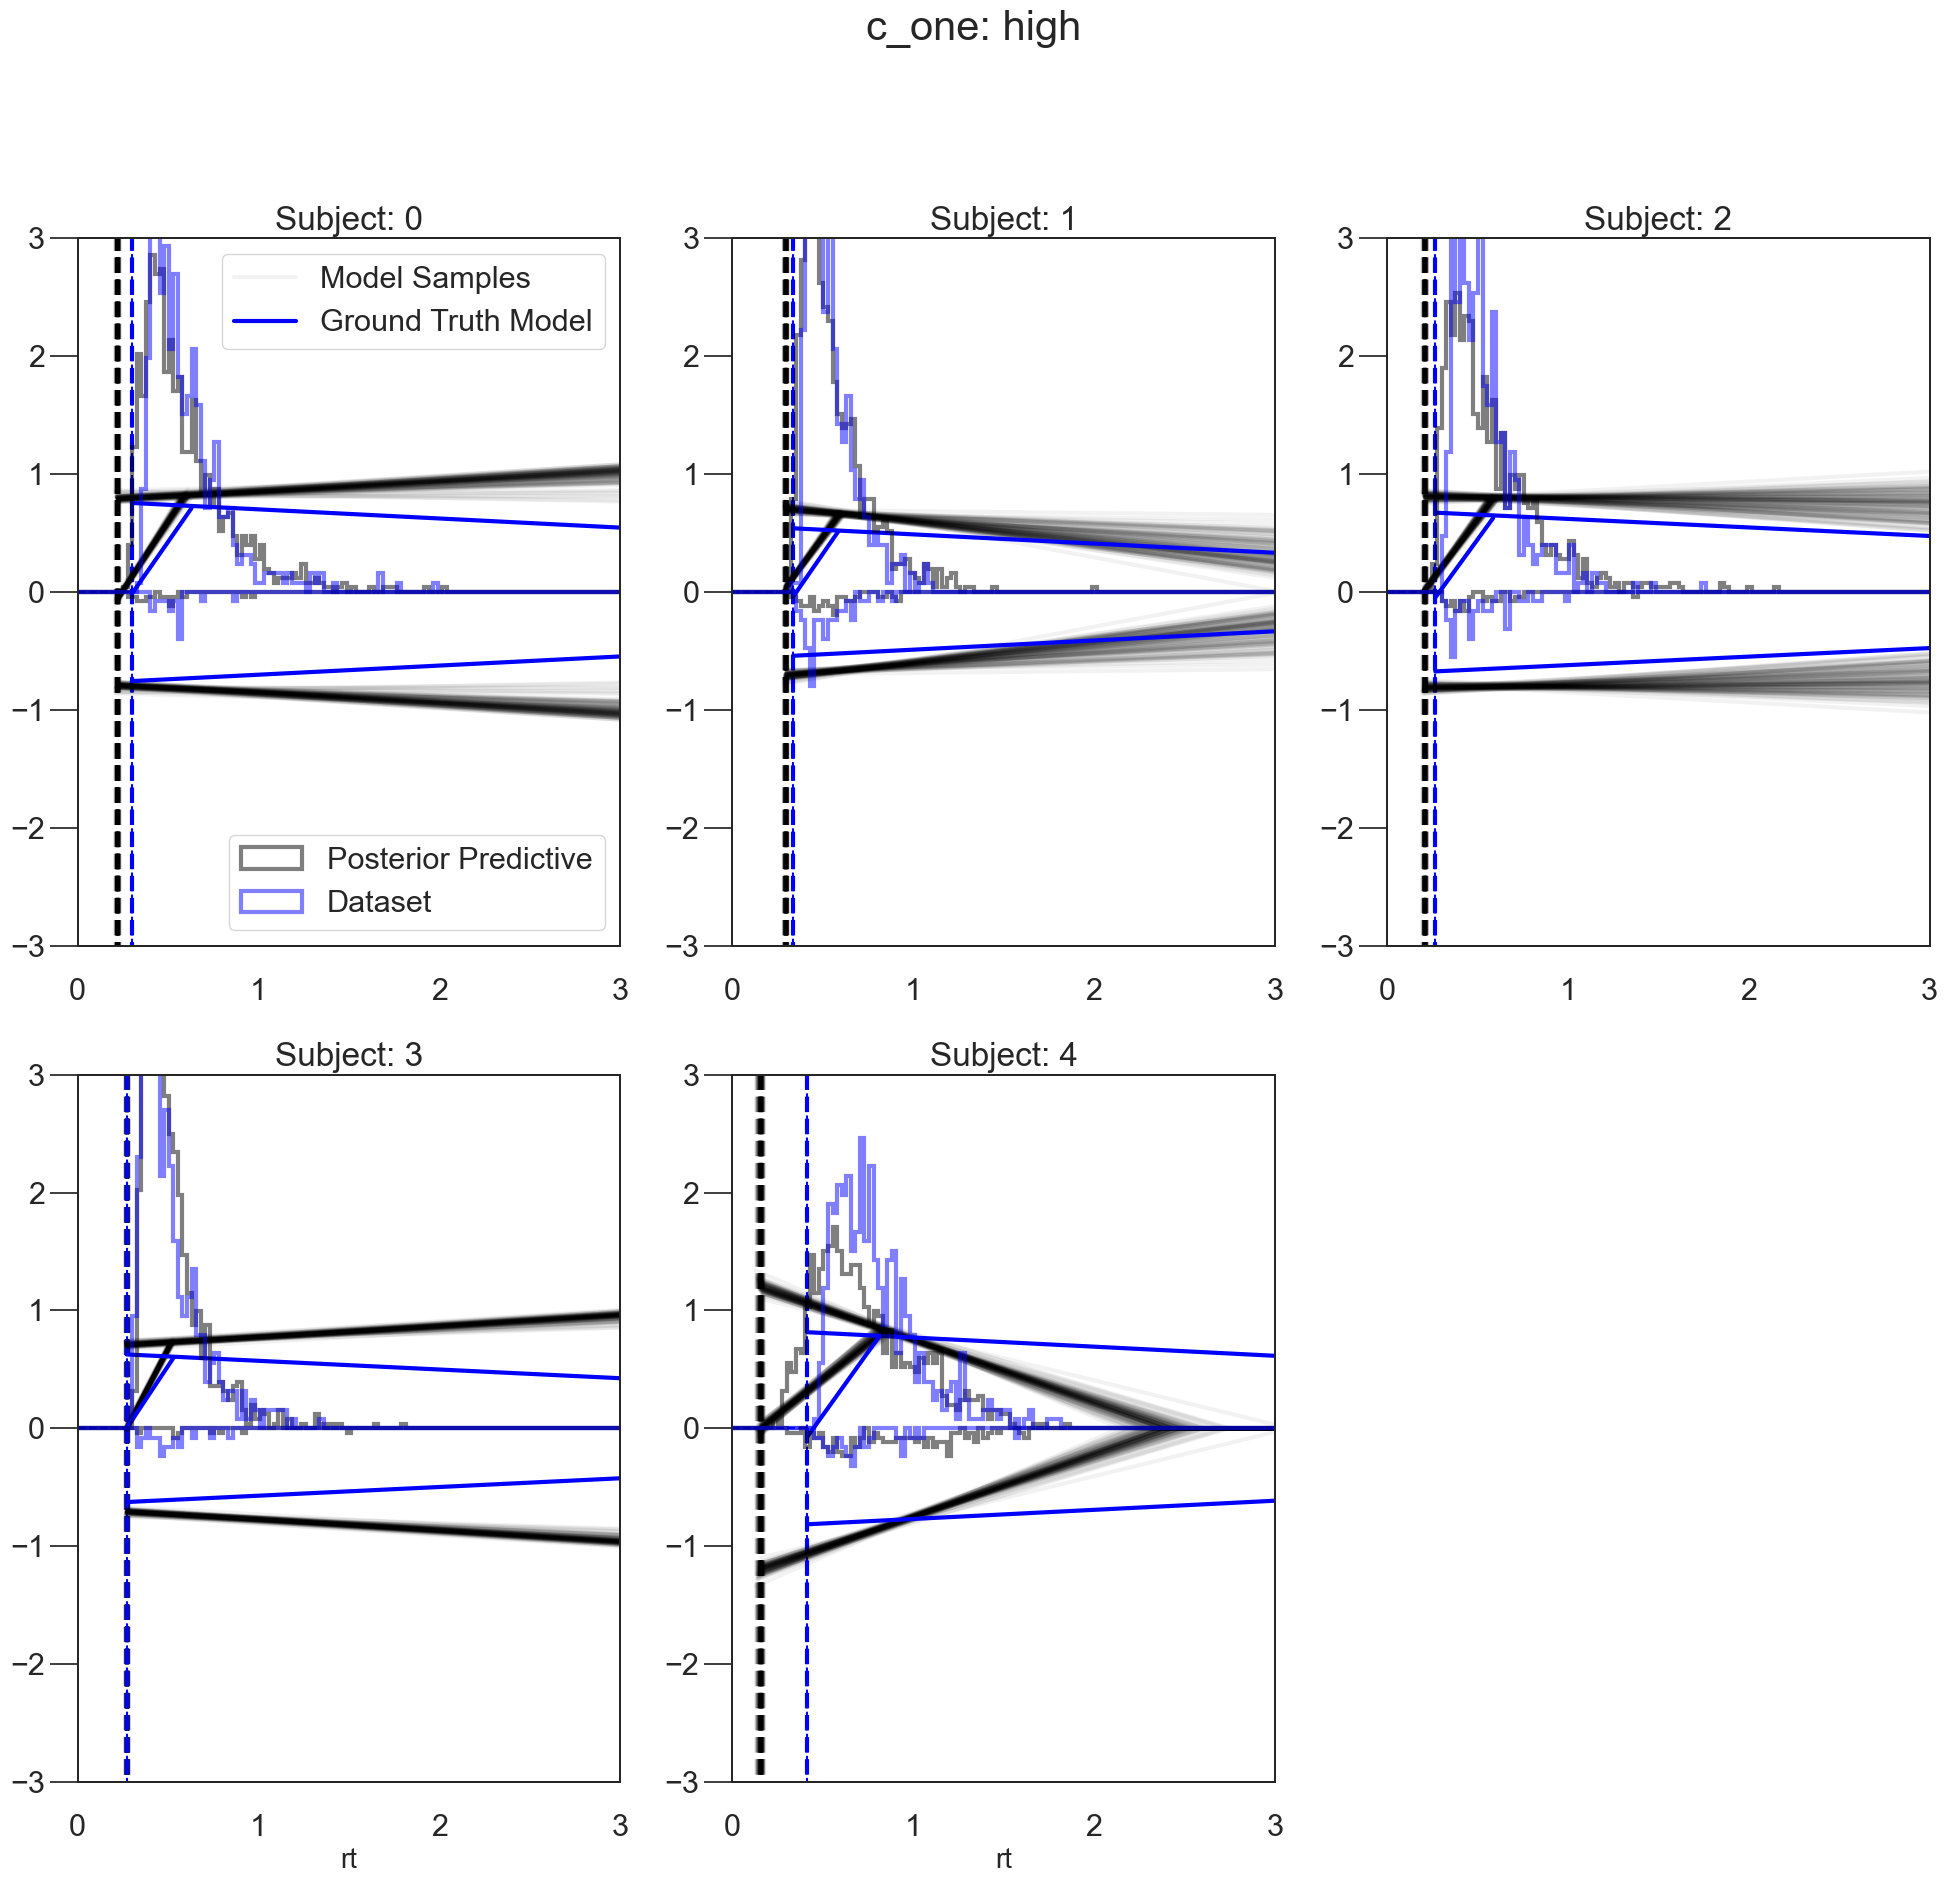

<Figure size 640x480 with 0 Axes>

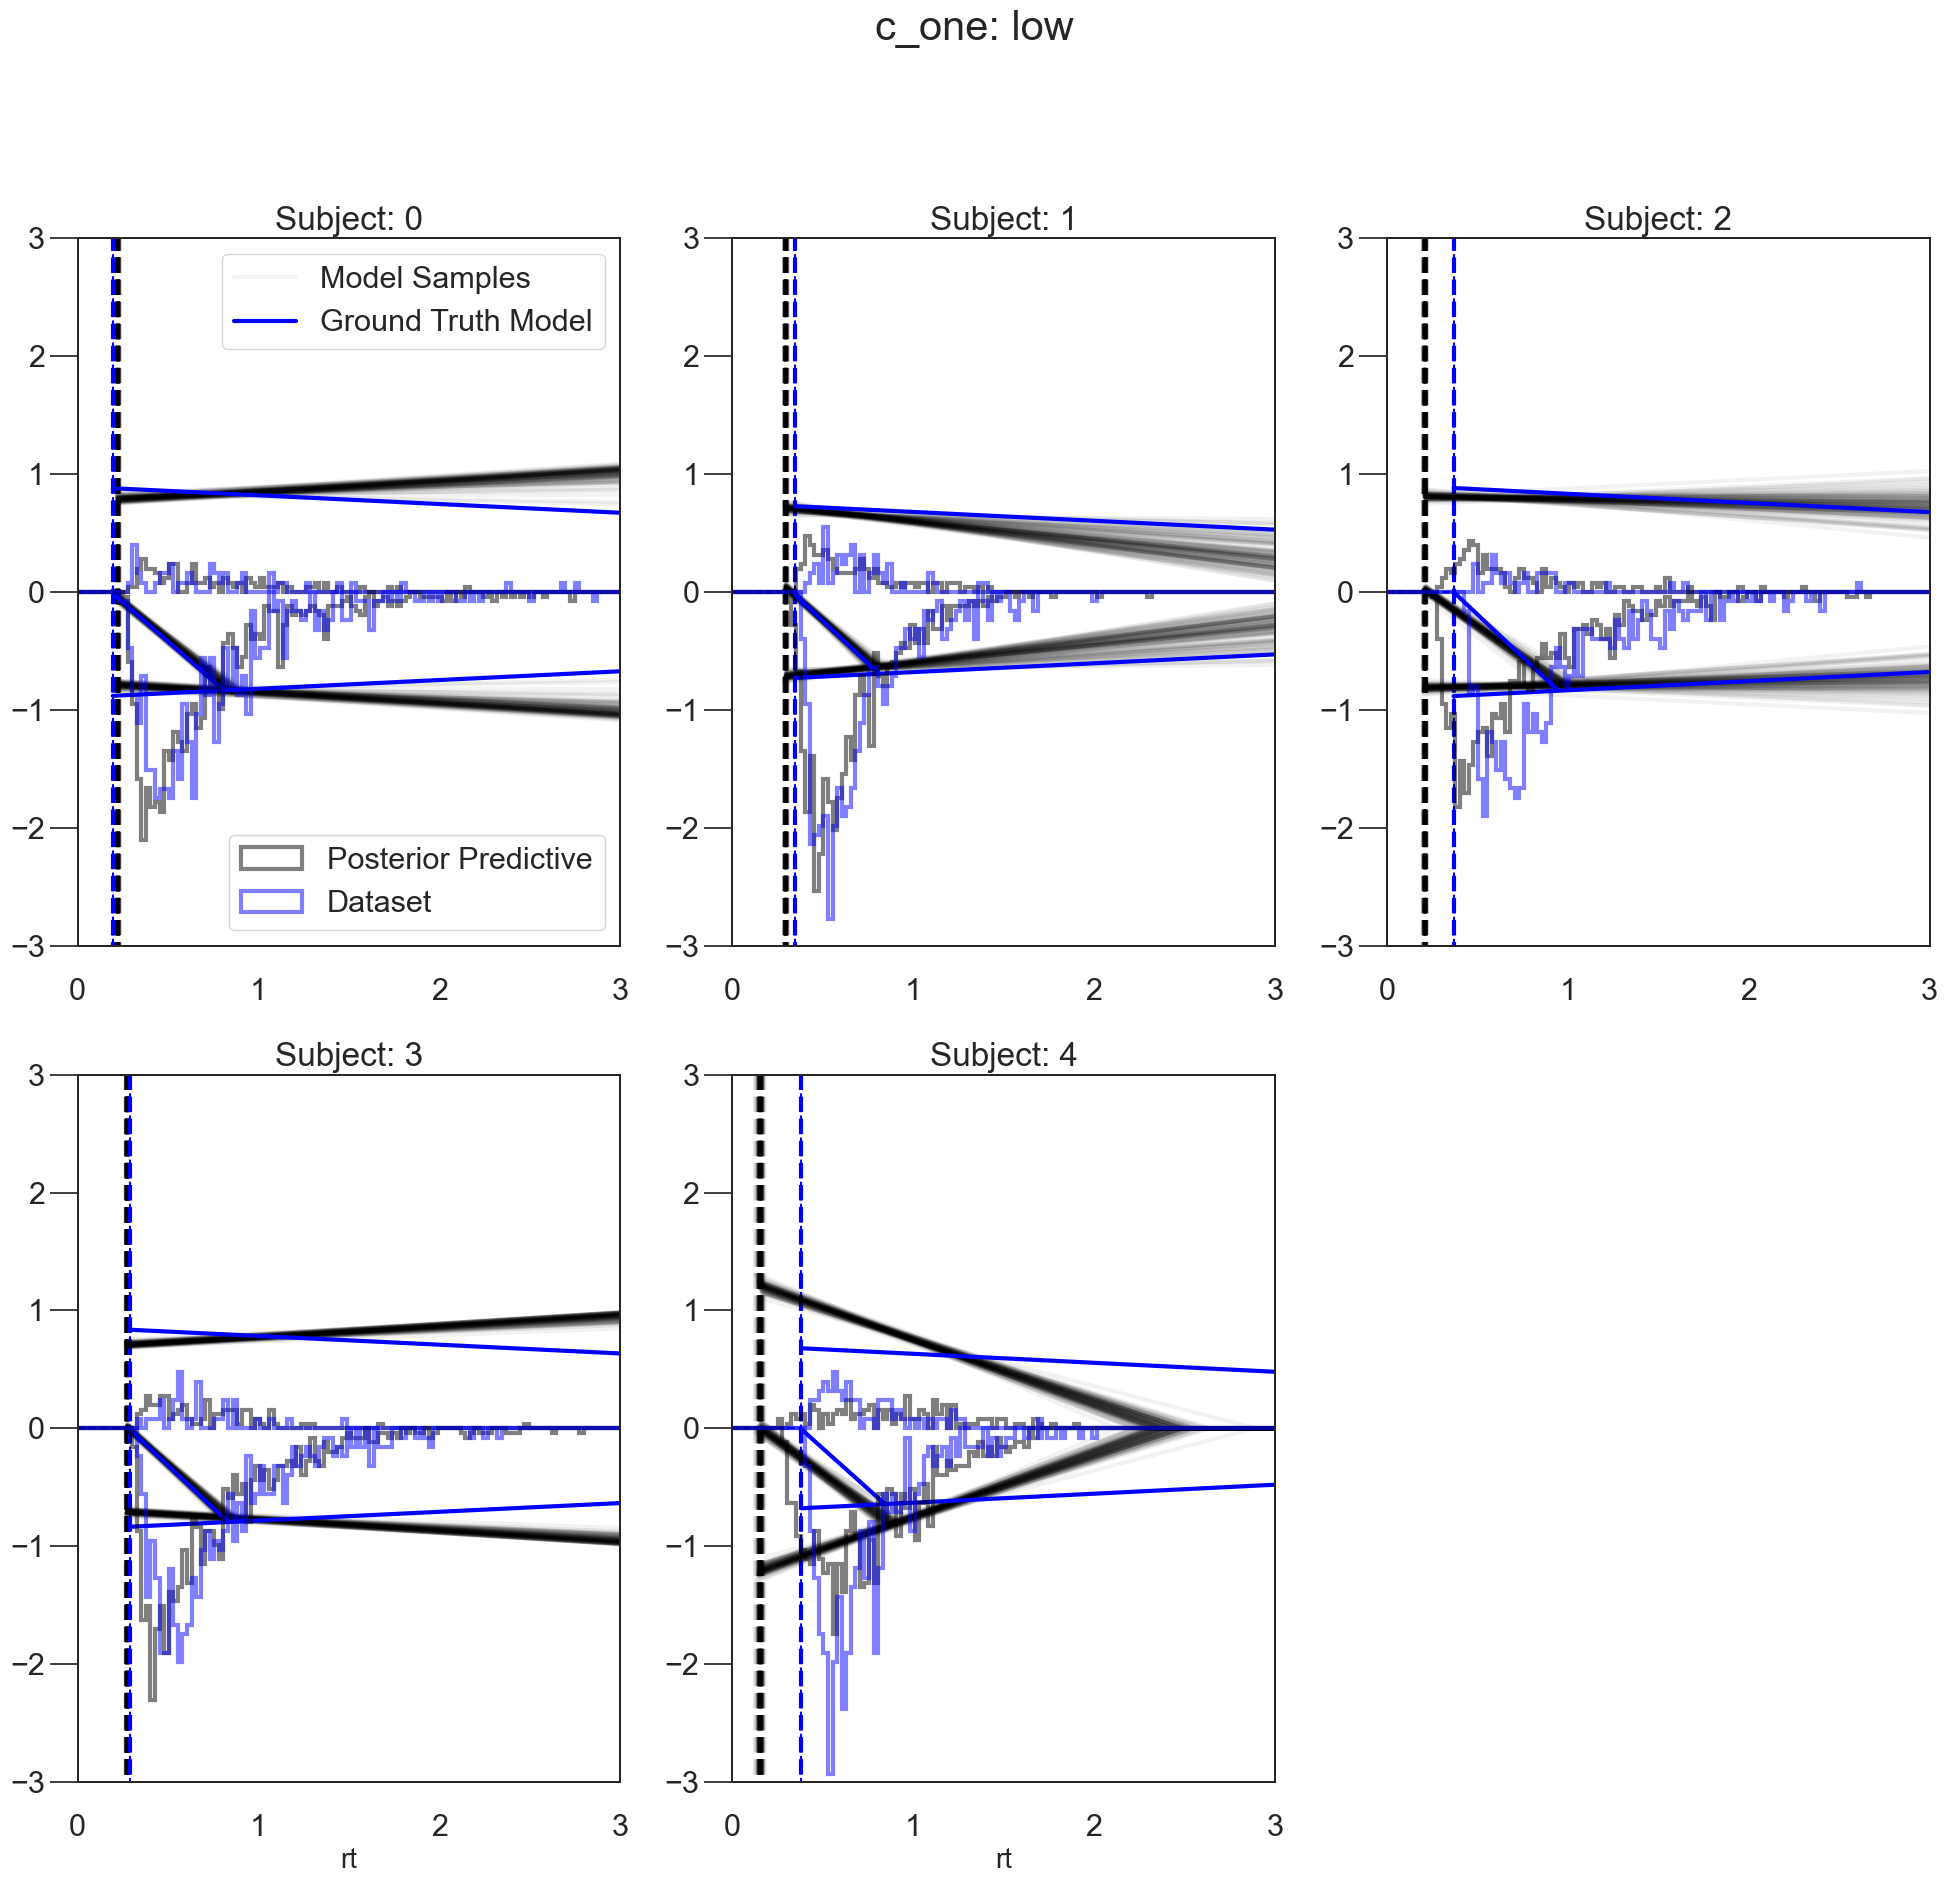

<Figure size 640x480 with 0 Axes>

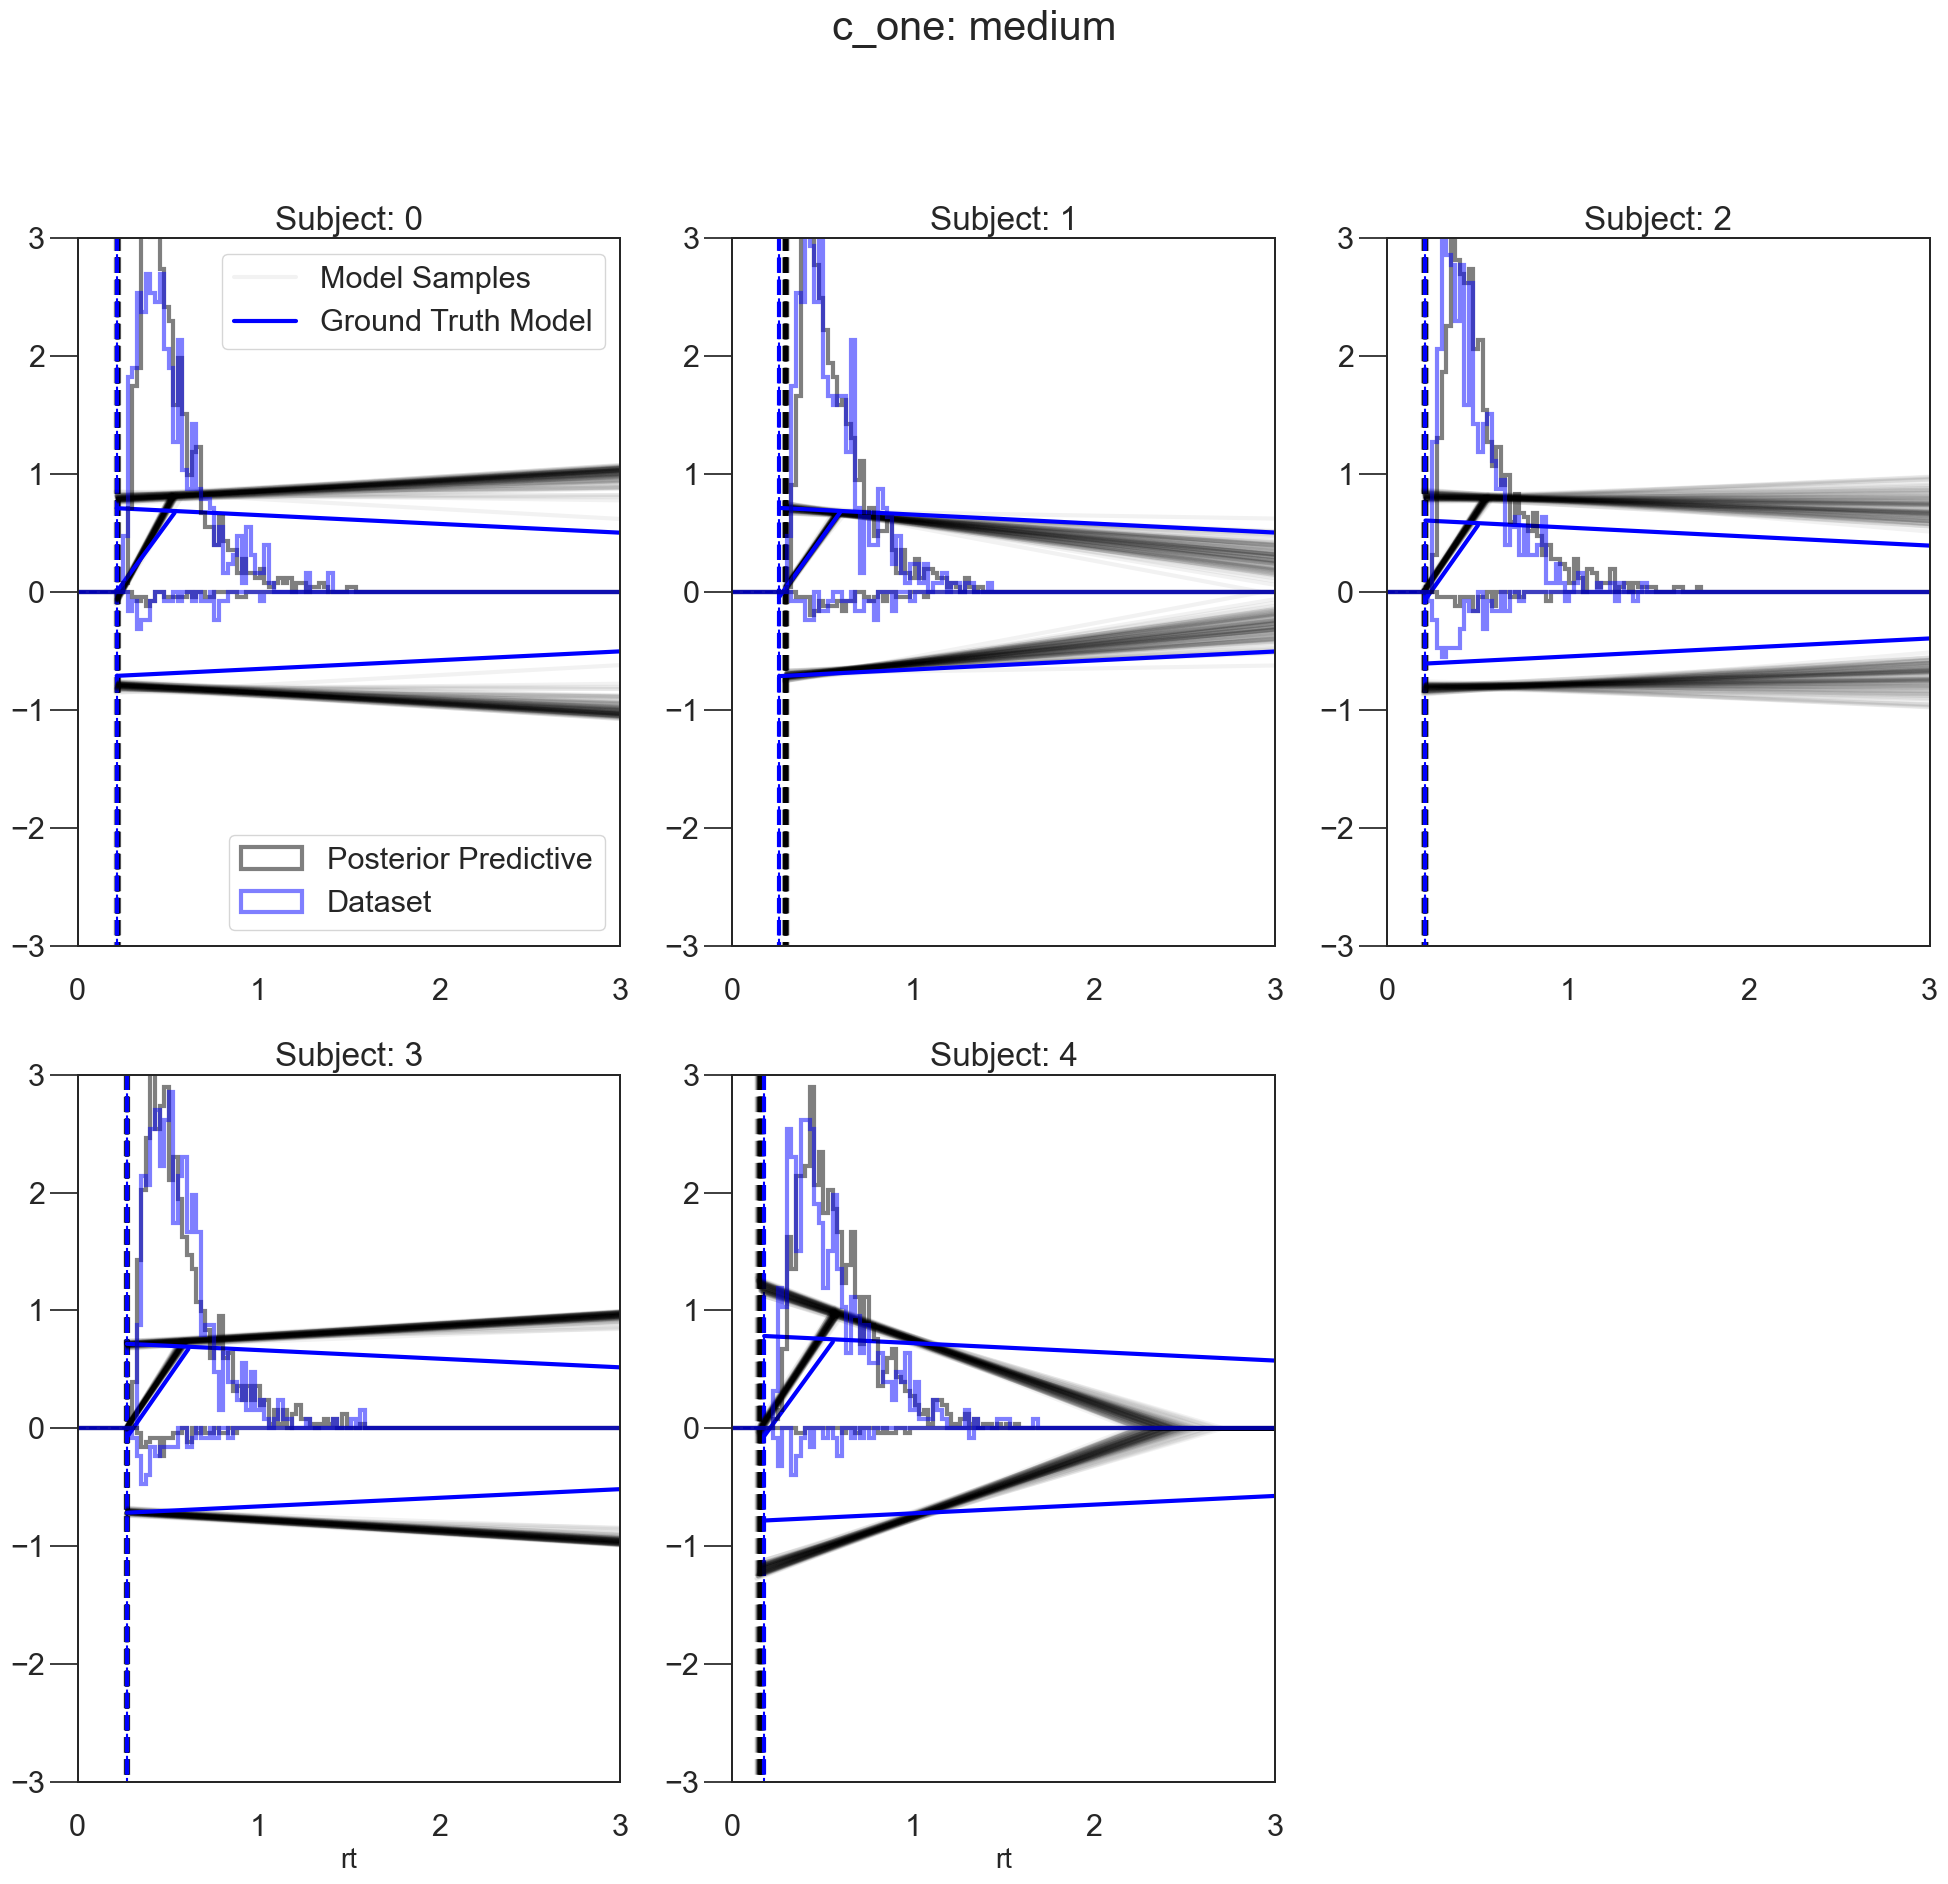

In [16]:
hddm.plotting.model_plot(hddm_model = hddmnn_model,
                       model_ground_truth= model,
                       grouped = False,
                       n_posterior_parameters = 100,
                       n_simulations_per_parameter = 10,
                       show_trajectories = False,
                       cols = 3,
                       show_model = True,
                       ylimit = 3,
                       max_t = 3,
                       scale_y = 0.5
                       )

<Figure size 640x480 with 0 Axes>

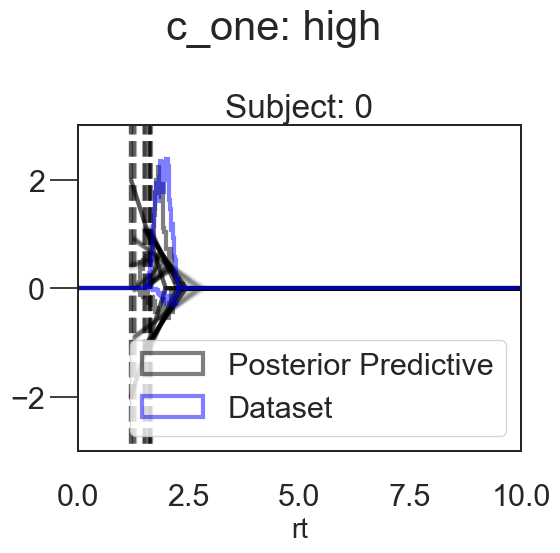

<Figure size 640x480 with 0 Axes>

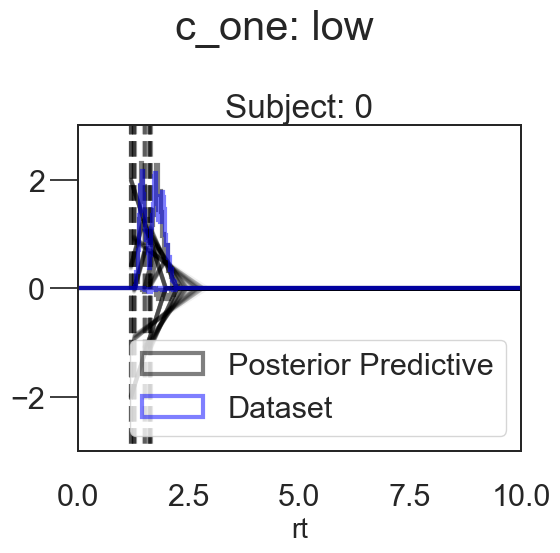

<Figure size 640x480 with 0 Axes>

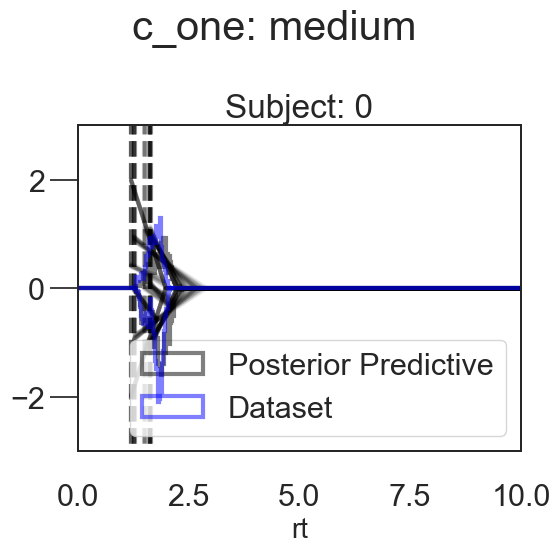

In [40]:
hddm.plotting.model_plot(hddm_model = hddmnn_model,
                       model_ground_truth= model,
                       grouped = True,
                       n_posterior_parameters = 100,
                       n_simulations_per_parameter = 10,
                       show_trajectories = False,
                       cols = 3,
                       show_model = True,
                       ylimit = 3,
                       max_t = 10,
                       scale_x = 0.3,
                       scale_y = 0.3,
                       )

# SECTION 5: REGRESSORS

This section provides a simple working example using the Neural Networks with the Regression backend.
The regression back-end allows linking parameters to trial-by-trial covariates via a (general) linear model.

In [17]:
# Metadata
nmcmc = 200
model = 'angle'
n_samples_by_subject = 500

In [18]:
# test regressors only False
# add p_outliers to the generator !
data, full_parameter_dict = hddm.simulators.hddm_dataset_generators.simulator_h_c(n_subjects = 3,
                                                                                  n_samples_by_subject = n_samples_by_subject,
                                                                                  model = model,
                                                                                  p_outlier = 0.00,
                                                                                  conditions = None, # {'c_one': ['low', 'medium', 'high']}, #, 'c_three': ['low', 'medium', 'high']},
                                                                                  depends_on = None, # {'v': ['c_one']}, # 'theta': ['c_two']}, # 'theta': ['c_two']}, #regression_models = None,
                                                                                  regression_models = ['t ~ 1 + covariate_name', 'v ~ 1 + covariate_name'], #regression_covariates = None, 
                                                                                  regression_covariates = {'covariate_name': {'type': 'continuous', 'range': (0, 1)}}, # need this to make initial covariate matrix from which to use dmatrix (patsy)
                                                                                  group_only_regressors = False,
                                                                                  group_only = None,
                                                                                  fixed_at_default = None)
                                                                                  #fixed_at_default = ['z'])

None
{'theta', 'a', 'z'}
1.286139906910426
-0.09337194490366807
new round of data simulation because parameter bounds where violated
0.9680952695191204
-0.9885334809269662


In [19]:
full_parameter_dict

{'theta': 0.4068128653556833,
 'theta_std': 0.013409183140274972,
 'a': 1.3927109646262152,
 'a_std': 0.06387845108211646,
 'z': 0.5608220000289668,
 'z_std': 0.05801684275382858,
 't_reg': OrderedDict([('t_Intercept', 0.9680952695191204),
              ('t_covariate_name', -0.004329339259400114)]),
 't_reg_std': OrderedDict([('t_Intercept_std', 0.18614104761909966),
              ('t_covariate_name_std', 0.005389082992913071)]),
 'v_reg': OrderedDict([('v_Intercept', -0.9885334809269662),
              ('v_covariate_name', 0.028787582876523415)]),
 'v_reg_std': OrderedDict([('v_Intercept_std', 0.4139116322152285),
              ('v_covariate_name_std', 0.09811634866864591)]),
 'theta_subj.0': 0.39404451377841443,
 'a_subj.0': 1.460182627945022,
 'z_subj.0': 0.5194229123045268,
 't_Intercept': 0.9680952695191204,
 't_covariate_name': -0.004329339259400114,
 't_Intercept_std': 0.18614104761909966,
 't_covariate_name_std': 0.005389082992913071,
 't_Intercept_subj.0': 1.1977371421579739,


In [20]:
# Set up the regressor a regressor:
reg_model_v = {'model': 'v ~ 1 + covariate_name', 'link_func': lambda x: x}
reg_model_t = {'model': 't ~ 1 + covariate_name', 'link_func': lambda x: x}
reg_descr = [reg_model_t, reg_model_v]

In [21]:
# Make HDDM model
hddmnn_reg = hddm.HDDMnnRegressor(data,
                                  reg_descr, 
                                  include = hddm.simulators.model_config[model]['hddm_include'],
                                  model = model,
                                  informative = False,
                                  p_outlier = 0.0)

Setting priors uninformative (LANs only work with uninformative priors for now)
Adding these covariates:
['t_Intercept', 't_covariate_name']
Adding these covariates:
['v_Intercept', 'v_covariate_name']
printing self.nn
True
passed through flip errors nn


In [22]:
# Sample
hddmnn_reg.sample(nmcmc, burn = 100)

boundary violation of regressor part
 [-----------------100%-----------------] 201 of 200 complete in 73.6 sec

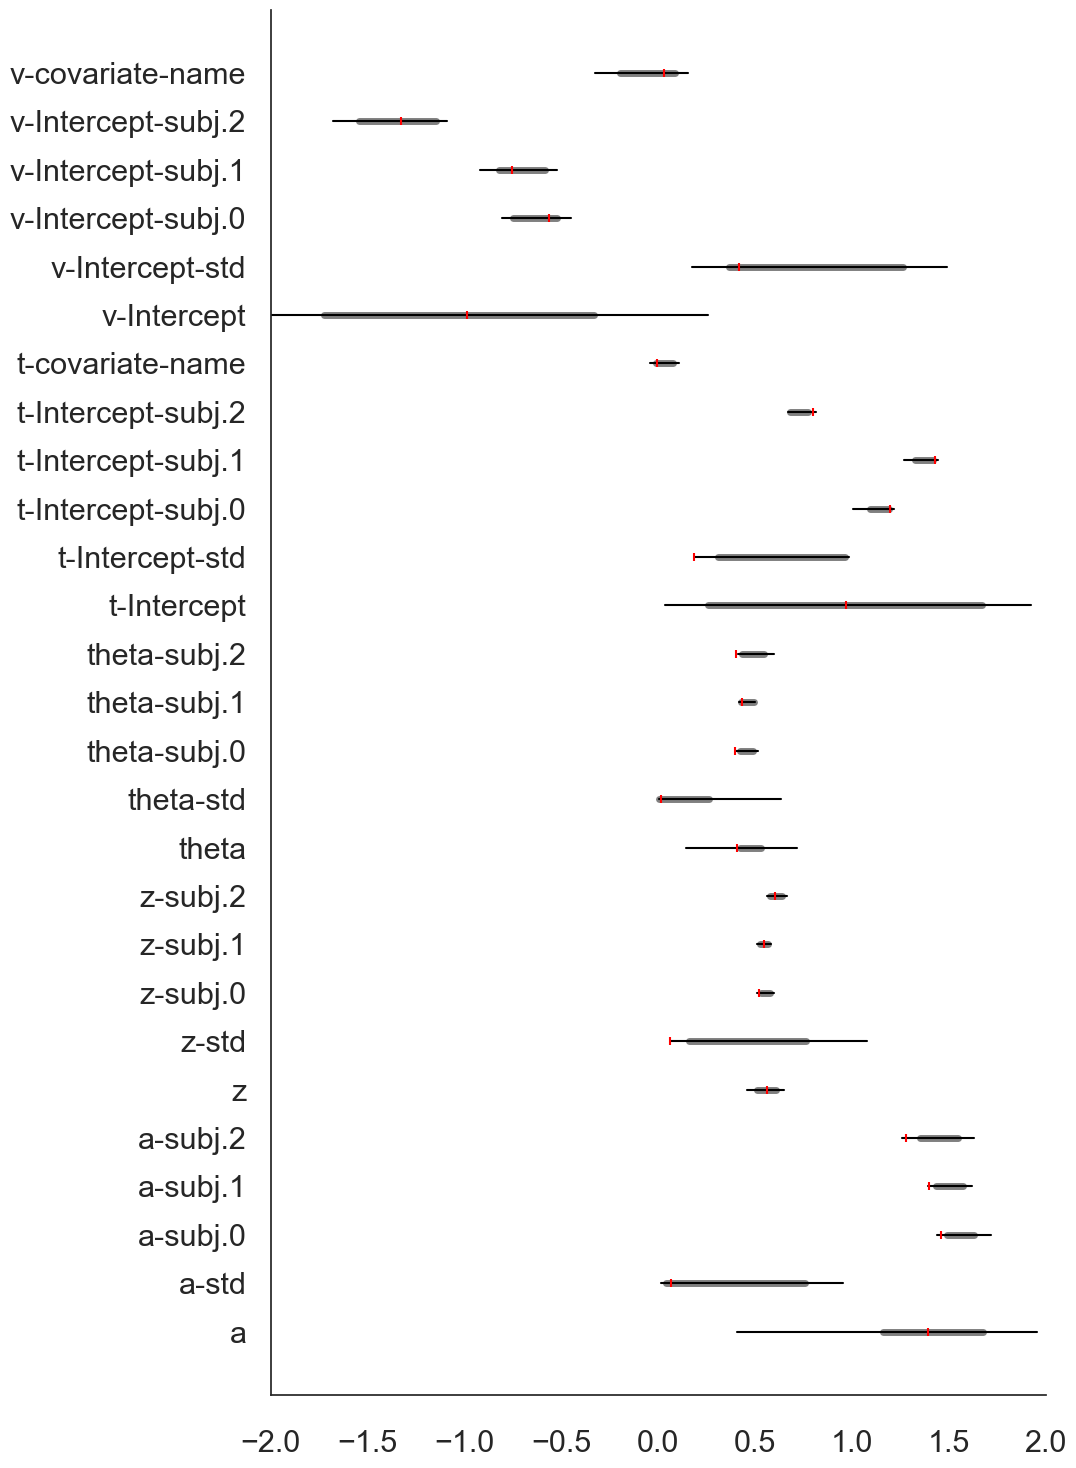

In [23]:
hddm.plotting.caterpillar_plot(hddm_model = hddmnn_reg,
                               ground_truth_parameter_dict = full_parameter_dict,
                               drop_sd = False,
                               )

# SECTION 6: STIM CODING

In [24]:
# Metadata
nmcmc = 300
model = 'ddm'
n_samples_by_condition = 500
split_param = 'v'

None
{'v', 't', 'theta', 'a', 'z'}


In [25]:
sim_data_stimcoding, parameter_dict = hddm.simulators.simulator_stimcoding(model = model,
                                                                           split_by = split_param,
                                                                           drift_criterion = 0.3,
                                                                           n_samples_by_condition = 500)

In [26]:
sim_data_stimcoding

rt  response  stim         v         a         z         t subj_idx
0    2.616296       0.0     1 -0.862947  2.304256  0.599804  1.653305     none
1    4.933249       0.0     1 -0.862947  2.304256  0.599804  1.653305     none
2    2.883307       0.0     1 -0.862947  2.304256  0.599804  1.653305     none
3    4.081311       0.0     1 -0.862947  2.304256  0.599804  1.653305     none
4    3.722337       0.0     1 -0.862947  2.304256  0.599804  1.653305     none
..        ...       ...   ...       ...       ...       ...       ...      ...
495  2.658296       1.0     2  1.462947  2.304256  0.599804  1.653305     none
496  4.229300       1.0     2  1.462947  2.304256  0.599804  1.653305     none
497  4.864255       1.0     2  1.462947  2.304256  0.599804  1.653305     none
498  2.581297       1.0     2  1.462947  2.304256  0.599804  1.653305     none
499  3.838329       1.0     2  1.462947  2.304256  0.599804  1.653305     none

[1000 rows x 8 columns]

In [27]:
parameter_dict

{'v': 1.1629472119522237,
 'a': 2.3042559685516943,
 'z': 0.599804386843174,
 't': 1.653305112594006,
 'dc': 0.3}

In [28]:
hddmnn_model = hddm.HDDMnnStimCoding(sim_data_stimcoding,
                                     include = hddm.simulators.model_config[model]['hddm_include'],
                                     model = model,
                                     stim_col = 'stim',
                                     p_outlier = 0.0,
                                     split_param = split_param,
                                     informative = False,
                                     drift_criterion = 0.3)

Setting priors uninformative (LANs only work with uninformative priors for now)
printing self.nn
True
passed through flip errors nn


In [29]:
hddmnn_model.sample(nmcmc, burn = 100)

 [-----------------100%-----------------] 300 of 300 complete in 35.8 sec

In [ ]:
hddmnn_model.get_traces()

a         v         t   z_trans        dc
0    1.943807 -1.627027  1.948819  0.321829  0.289607
1    1.918583 -1.613760  1.959870  0.324705  0.314593
2    1.906834 -1.612909  1.976932  0.400249  0.340777
3    1.886101 -1.618093  1.975456  0.330379  0.380979
4    1.871423 -1.597477  1.978713  0.280095  0.389332
..        ...       ...       ...       ...       ...
195  1.809673 -1.581544  1.997459  0.439645  0.261857
196  1.804171 -1.539146  1.996878  0.435181  0.254404
197  1.786686 -1.575021  1.999747  0.434047  0.300928
198  1.802647 -1.540104  1.992041  0.425610  0.294060
199  1.789840 -1.513673  1.993103  0.363665  0.289061

[200 rows x 5 columns]

In [30]:
hddmnn_model.gen_stats()

mean        std      2.5q       25q       50q       75q     97.5q  \
v     1.1605  0.0315513   1.10249   1.14004   1.15589   1.18444   1.22443   
a     2.3495  0.0684855   2.21035   2.30285   2.34321   2.40306   2.47354   
z   0.600749  0.0114279  0.578778  0.593997  0.600859  0.606923  0.623253   
t     1.6748   0.034122   1.61043   1.65167   1.67651   1.70085   1.74776   
dc  0.273747  0.0339156   0.21189  0.252209  0.273652  0.293451   0.34688   

        mc err  
v   0.00269163  
a   0.00655973  
z    0.0010279  
t   0.00312307  
dc  0.00306146

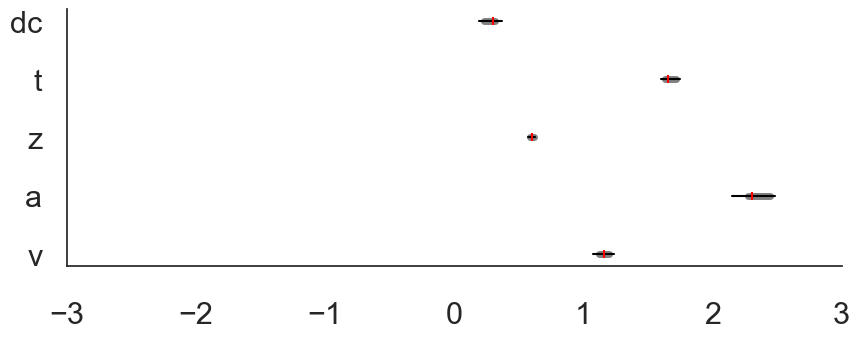

In [32]:
hddm.plotting.caterpillar_plot(hddm_model = hddmnn_model,
                             ground_truth_parameter_dict = parameter_dict,
                             drop_sd = False,
                             x_limits = [-3, 3])

### NOTE: 

The `hddm.plotting.model_plot()`, `hddm.plotting.posterior_predictive_plot()`, and `hddm.plotting.caterpillar_plot()` function do not yet *stimcoding* data. This will be updated as soon as possible.

# SECTION 7: MODEL RECOVERY

Lastly we are going to look at model recovery, because it is tempting now that we have three kinds of models at our hands ( **ddm / angle / weibull **). 

For the little model recovery study we conduct here, we generate data from the **weibull** model and fit the data once each to the  **weibull**, **angle** and **ddm** models.

We inspect the fits visually and then use the *DIC* (Deviance information criterion, lower is better :)), to check if we can recover the **true** model. 

In [33]:
# Metadata
model = 'weibull_cdf'
n_samples = 300

In [34]:
# test regressors only False
# add p_outliers to the generator !
data, full_parameter_dict = hddm.simulators.hddm_dataset_generators.simulator_h_c(n_subjects = 1,
                                                                                  n_samples_by_subject = n_samples,
                                                                                  model = model,
                                                                                  p_outlier = 0.00,
                                                                                  conditions = None, #{'c_one': ['low', 'medium', 'high']}, #, 'c_three': ['low', 'medium', 'high']},
                                                                                  depends_on = None, #{'v': ['c_one']}, # 'theta': ['c_two']}, # 'theta': ['c_two']}, #regression_models = None, #
                                                                                  regression_models = None, #regression_covariates = None, 
                                                                                  regression_covariates = None, # need this to make initial covariate matrix from which to use dmatrix (patsy)
                                                                                  group_only_regressors = False,
                                                                                  group_only = None,
                                                                                  fixed_at_default = None)
                                                                                  #fixed_at_default = ['z'])

None
{'t', 'a', 'v', 'beta', 'alpha', 'z'}
new round of data simulation because parameter bounds where violated


In [35]:
data

rt  response subj_idx         v         a         z         t  \
0    1.602302       1.0        0  0.967636  1.628068  0.780847  1.378302   
1    1.583302       1.0        0  0.967636  1.628068  0.780847  1.378302   
2    2.017297       1.0        0  0.967636  1.628068  0.780847  1.378302   
3    1.762300       1.0        0  0.967636  1.628068  0.780847  1.378302   
4    1.507302       1.0        0  0.967636  1.628068  0.780847  1.378302   
..        ...       ...      ...       ...       ...       ...       ...   
295  1.470302       1.0        0  0.967636  1.628068  0.780847  1.378302   
296  1.734301       1.0        0  0.967636  1.628068  0.780847  1.378302   
297  1.801300       1.0        0  0.967636  1.628068  0.780847  1.378302   
298  1.764300       1.0        0  0.967636  1.628068  0.780847  1.378302   
299  1.681301       1.0        0  0.967636  1.628068  0.780847  1.378302   

        alpha      beta  
0    4.346049  5.083114  
1    4.346049  5.083114  
2    4.346049  5.083114  
3    4.346049  5.083114  
4    4.346049  5.083114  
..        ...       ...  
295  4.346049  5.083114  
296  4.346049  5.083114  
297  4.346049  5.083114  
298  4.346049  5.083114  
299  4.346049  5.083114  

[300 rows x 9 columns]

In [37]:
# Now we fit for each model:
hddmnn_model_weibull = hddm.HDDMnn(data, 
                                   informative = False,
                                   model = 'weibull',
                                   p_outlier = 0.0,
                                   include = hddm.simulators.model_config['weibull_cdf']['hddm_include'], # hddm_include_config['weibull_cdf'],
                                   is_group_model = False)

hddmnn_model_angle = hddm.HDDMnn(data, 
                                 model = 'angle',
                                 informative = False,
                                 p_outlier = 0.0,
                                 include = hddm.simulators.model_config['angle']['hddm_include'],
                                 is_group_model = False)

hddmnn_model_ddm = hddm.HDDMnn(data, 
                               informative = False, 
                               model = 'ddm',
                               p_outlier = 0.0,
                               include = hddm.simulators.model_config['ddm']['hddm_include'],
                               is_group_model = False)

Setting priors uninformative (LANs only work with uninformative priors for now)
printing self.nn
True
passed through flip errors nn
Setting priors uninformative (LANs only work with uninformative priors for now)
printing self.nn
True
passed through flip errors nn
Setting priors uninformative (LANs only work with uninformative priors for now)
printing self.nn
True
passed through flip errors nn


In [38]:
nmcmc = 200
hddmnn_model_weibull.sample(nmcmc, 
                            burn = 100)

hddmnn_model_angle.sample(nmcmc, 
                          burn = 100)

hddmnn_model_ddm.sample(nmcmc, 
                        burn = 100)

 [-----------------100%-----------------] 200 of 200 complete in 9.9 secc

In [39]:
hddmnn_model_angle.data

rt  response subj_idx         v         a         z         t  \
0    1.602302       1.0        0  0.967636  1.628068  0.780847  1.378302   
1    1.583302       1.0        0  0.967636  1.628068  0.780847  1.378302   
2    2.017297       1.0        0  0.967636  1.628068  0.780847  1.378302   
3    1.762300       1.0        0  0.967636  1.628068  0.780847  1.378302   
4    1.507302       1.0        0  0.967636  1.628068  0.780847  1.378302   
..        ...       ...      ...       ...       ...       ...       ...   
295  1.470302       1.0        0  0.967636  1.628068  0.780847  1.378302   
296  1.734301       1.0        0  0.967636  1.628068  0.780847  1.378302   
297  1.801300       1.0        0  0.967636  1.628068  0.780847  1.378302   
298  1.764300       1.0        0  0.967636  1.628068  0.780847  1.378302   
299  1.681301       1.0        0  0.967636  1.628068  0.780847  1.378302   

        alpha      beta  
0    4.346049  5.083114  
1    4.346049  5.083114  
2    4.346049  5.083114  
3    4.346049  5.083114  
4    4.346049  5.083114  
..        ...       ...  
295  4.346049  5.083114  
296  4.346049  5.083114  
297  4.346049  5.083114  
298  4.346049  5.083114  
299  4.346049  5.083114  

[300 rows x 9 columns]

### CHECKING THE MODEL FITS VISUALLY

Posterior Predictive: Do the 'Posterior Models' also make sense?

<Figure size 640x480 with 0 Axes>

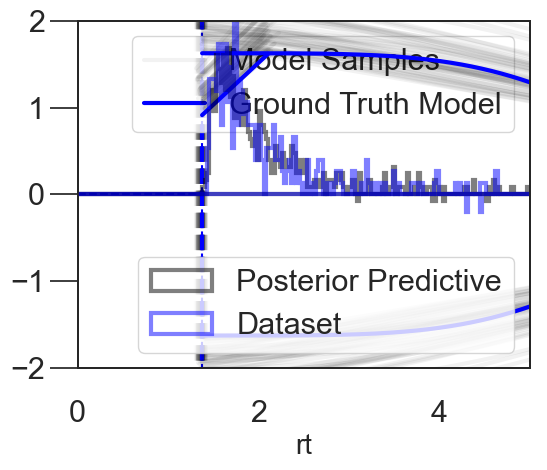

In [42]:
hddm.plotting.model_plot(hddm_model = hddmnn_model_weibull, #ground_truth_parameters = sim_data_recov[2],
                       model_ground_truth = model,
                       n_posterior_parameters = 50,
                       cols = 1,
                       max_t = 5,
                       show_model = True,
                       scale_x = 0.3,
                       scale_y = 0.3,
                       )

<Figure size 640x480 with 0 Axes>

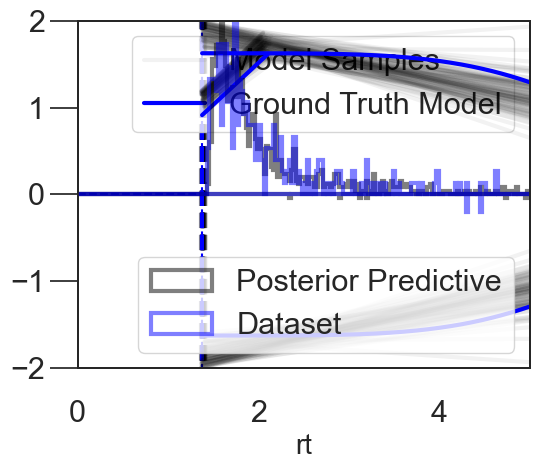

In [44]:
hddm.plotting.model_plot(hddm_model = hddmnn_model_angle, #ground_truth_parameters = sim_data_recov[2],
                       model_ground_truth = model,
                       n_posterior_parameters = 100,
                       cols = 1,
                       max_t = 5,
                       show_model = True,
                       scale_x = 0.3,
                       scale_y = 0.3,
                       )

<Figure size 640x480 with 0 Axes>

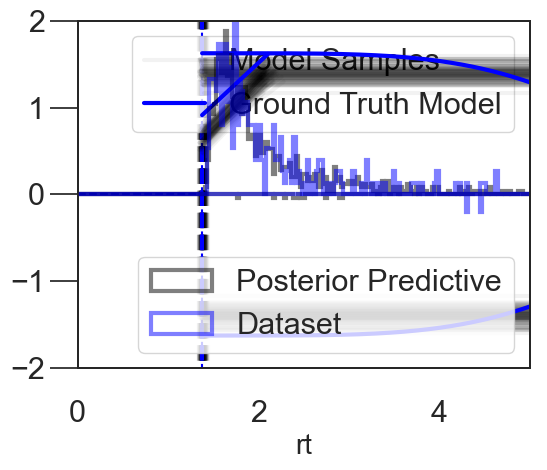

In [46]:
hddm.plotting.model_plot(hddm_model = hddmnn_model_ddm, #ground_truth_parameters = sim_data_recov[2],
                       model_ground_truth = model,
                       n_posterior_parameters = 100,
                       cols = 1,
                       max_t = 5,
                       show_model = True,
                       scale_x = 0.3,
                       scale_y = 0.3,
                       )

### Let's compare the DIC's 

In [47]:
hddmnn_model_weibull.dic

357.6258978271485

In [48]:
hddmnn_model_angle.dic

356.1899780273437

In [49]:
hddmnn_model_ddm.dic

378.0987768554687

**Fingers crossed** (this was a random run after all), the DIC usually gives us a result that conforms with the intuition we get from looking at the model plots. 

# SECTION 8: REAL DATA?

In [56]:
# Metadata
nmcmc = 500
burn = 100
model = 'angle'
n_samples_by_subject = 500
n_subjects = 5

#### Load and Pre-process dataset

In [57]:
# Load one of the datasets shipping with HDDM
cav_data = hddm.load_csv(hddm.__path__[0] + '/examples/cavanagh_theta_nn.csv')

In [58]:
cav_data

subj_idx stim     rt  response     theta  dbs conf
0            0   LL  1.210       1.0  0.656275    1   HC
1            0   WL  1.630       1.0 -0.327889    1   LC
2            0   WW  1.030       1.0 -0.480285    1   HC
3            0   WL  2.770       1.0  1.927427    1   LC
4            0   WW  1.140       0.0 -0.213236    1   HC
...        ...  ...    ...       ...       ...  ...  ...
3983        13   LL  1.450       0.0 -1.237166    0   HC
3984        13   WL  0.711       1.0 -0.377450    0   LC
3985        13   WL  0.784       1.0 -0.694194    0   LC
3986        13   LL  2.350       0.0 -0.546536    0   HC
3987        13   WW  1.250       1.0  0.752388    0   HC

[3988 rows x 7 columns]

#### Basic Condition Split Model

In [59]:
hddmnn_model_cav = hddm.HDDMnn(cav_data,
                         model = model,
                         informative = False,
                         include = hddm.simulators.model_config[model]['hddm_include'],
                         p_outlier = 0.05,
                         is_group_model = False,
                         depends_on = {'v': 'stim'})

Setting priors uninformative (LANs only work with uninformative priors for now)
printing self.nn
True
passed through flip errors nn


In [60]:
hddmnn_model_cav.sample(nmcmc, burn = burn)

 [-----------------100%-----------------] 501 of 500 complete in 200.6 sec

In [61]:
hddm.plotting.model_plot(hddm_model = hddmnn_model_cav,
                       model_ground_truth = None,
                       n_posterior_parameters = 50,
                       cols = 3,
                       max_t = 5,
                       scale_y = 0.5,
                       scale_x = 0.5,
                       show_model = True)

SyntaxError: invalid syntax (<ipython-input-61-987761493e42>, line 8)

In [ ]:
hddmnn_model_cav.get_traces()

In [ ]:
hddm.plotting.posterior_predictive_plot(hddm_model = hddmnn_model_cav,
                                      model_ground_truth = None,
                                      n_posterior_parameters = 100,
                                      max_t = 5,
                                      hist_linewidth = 3,
                                      bin_size = 0.1)

#### Basic Hierarchical Model

In [6]:
hddmnn_model_cav = hddm.HDDMnn(cav_data,
                               model = model,
                               informative = False,
                               include = hddm.simulators.model_config[model]['hddm_include'], #is_group_model = True,
                               p_outlier = 0.05)

{'model': 'angle', 'informative': False, 'include': ['z', 'theta'], 'p_outlier': 0.05}
angle
Now adding the HDDMBase include:
Include from inside HDDMBase:  {'a', 't', 'v'}
Recognized HDDMnn
RT
0.402
4.84
Response
[-1.  1.]
printing include: 
{'a', 'z', 'theta', 't', 'v'}
knodes
OrderedDict([('a', a), ('a_std', a_std), ('a_tau', a_tau), ('a_bottom', a_subj), ('v', v), ('v_std', v_std), ('v_tau', v_tau), ('v_bottom', v_subj), ('t', t), ('t_std', t_std), ('t_tau', t_tau), ('t_bottom', t_subj), ('z_trans', z_trans), ('z', z), ('z_std', z_std), ('z_tau', z_tau), ('z_subj_trans', z_subj_trans), ('z_bottom', z_subj), ('theta', theta), ('theta_std', theta_std), ('theta_tau', theta_tau), ('theta_bottom', theta_subj)])
printing knodes
OrderedDict([('a', a), ('a_std', a_std), ('a_tau', a_tau), ('a_bottom', a_subj), ('v', v), ('v_std', v_std), ('v_tau', v_tau), ('v_bottom', v_subj), ('t', t), ('t_std', t_std), ('t_tau', t_tau), ('t_bottom', t_subj), ('z_trans', z_trans), ('z', z), ('z_std', z_std

In [7]:
hddmnn_model_cav.sample(nmcmc, burn = burn)

 [-----------------100%-----------------] 201 of 200 complete in 454.9 sec

model_ground_truth
None
data_h_c[key][subj_id[data]
['subj_idx', 'stim', 'rt', 'response', 'theta', 'dbs', 'conf']
test_passed
0
model_ground_truth
None
data_h_c[key][subj_id[data]
['subj_idx', 'stim', 'rt', 'response', 'theta', 'dbs', 'conf']
test_passed
0
model_ground_truth
None
data_h_c[key][subj_id[data]
['subj_idx', 'stim', 'rt', 'response', 'theta', 'dbs', 'conf']
test_passed
0
model_ground_truth
None
data_h_c[key][subj_id[data]
['subj_idx', 'stim', 'rt', 'response', 'theta', 'dbs', 'conf']
test_passed
0
model_ground_truth
None
data_h_c[key][subj_id[data]
['subj_idx', 'stim', 'rt', 'response', 'theta', 'dbs', 'conf']
test_passed
0
model_ground_truth
None
data_h_c[key][subj_id[data]
['subj_idx', 'stim', 'rt', 'response', 'theta', 'dbs', 'conf']
test_passed
0
model_ground_truth
None
data_h_c[key][subj_id[data]
['subj_idx', 'stim', 'rt', 'response', 'theta', 'dbs', 'conf']
test_passed
0
model_ground_truth
None
data_h_c[key][subj_id[data]
['subj_idx', 'stim', 'rt', 'response', 'theta

<Figure size 640x480 with 0 Axes>

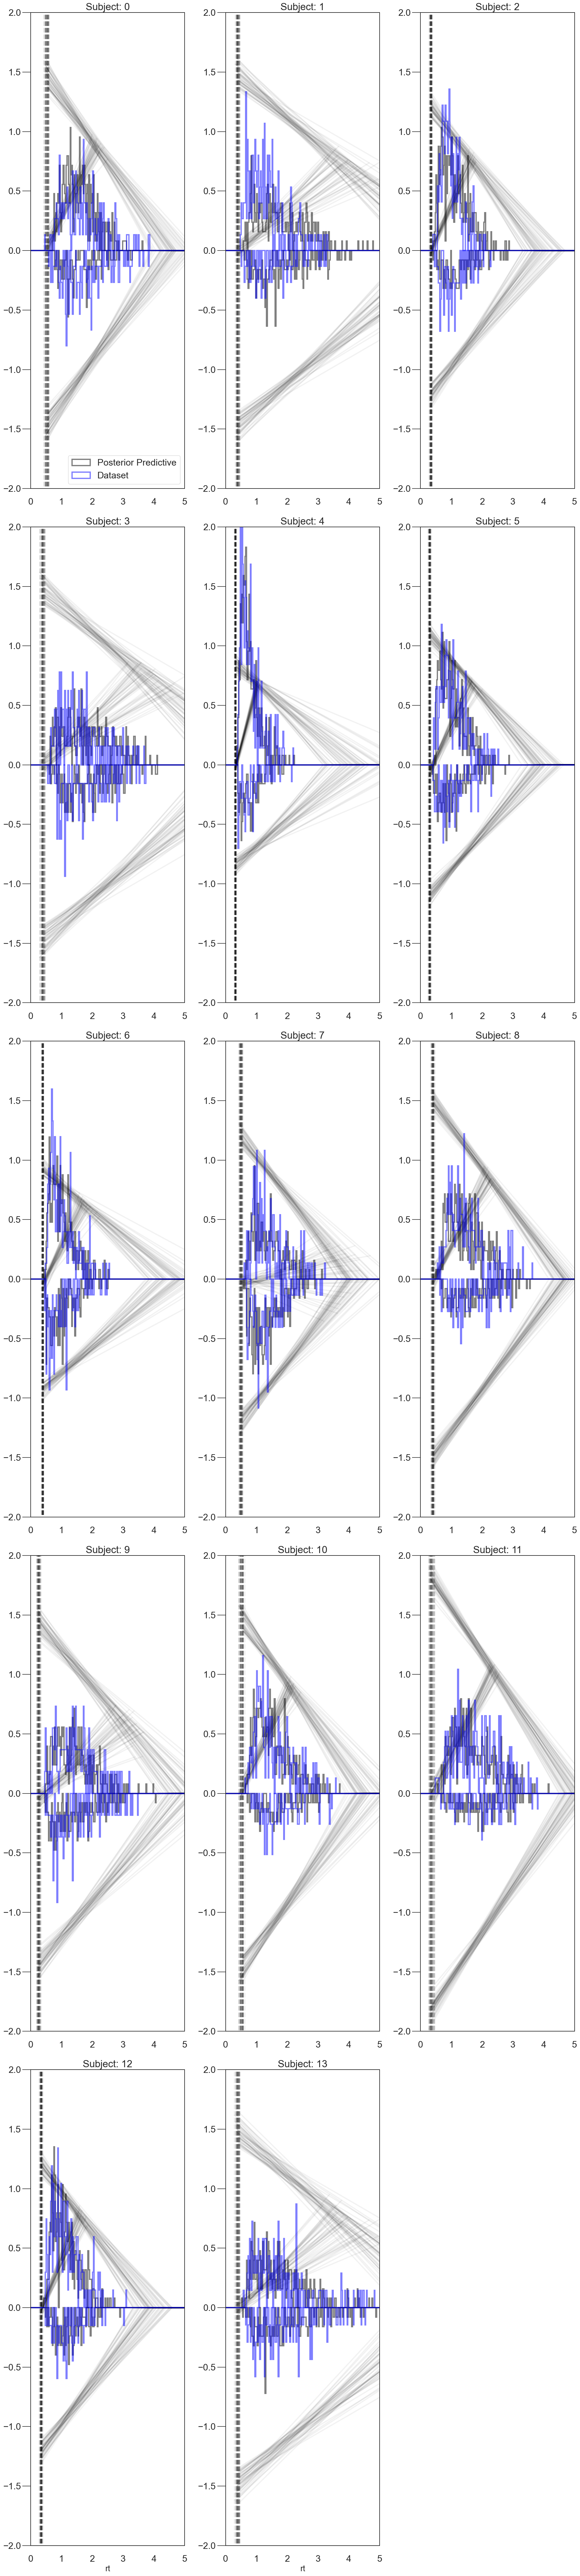

In [10]:
hddm.plotting.model_plot(hddm_model = hddmnn_model_cav,
                       model_ground_truth = None,
                       n_posterior_parameters = 50,
                       cols = 3,
                       max_t = 5,
                       show_model = True)

In [20]:
hddm.plotting.posterior_predictive_plot(hddm_model = hddmnn_model_cav,
                                       model_ground_truth= None,
                                       n_posterior_parameters = 100,
                                       max_t = 5,
                                       hist_linewidth = 3,
                                       bin_size = 0.1)

NameError: name 'hddmnn_model_cav' is not defined

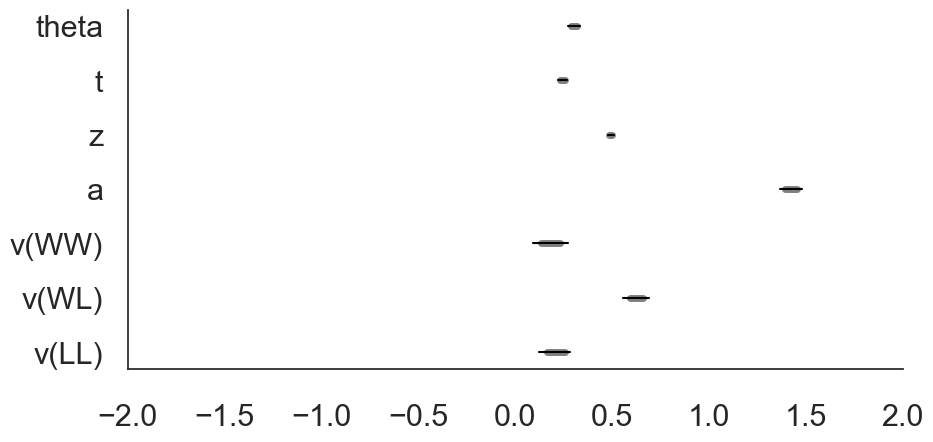

In [62]:
# Caterpillar Plot: (Parameters recovered ok?)
hddm.plotting.caterpillar_plot(hddm_model = hddmnn_model_cav,
                             ground_truth_parameter_dict = None, #weibull_params.values[0],
                             drop_sd = False)

### Note

This is just an example using the Cavanagh dataset. The angle model might not be the best choice here, and we are moreover ignoring the supplied conditions. 

# 9. ACCESSING THE NEURAL NETWORK DIRECTLY

The ```network_inspectors``` module allows you to inspect the LANs directly. We will be grateful if you report any strange behavior you might find.

### 9.1 Direct access to batch predictions

 

You can use the ```hddm.network_inspectors.get_torch_mlp()``` function to access network predictions.

In [63]:
model = 'angle'

In [1]:
lan_angle = hddm.network_inspectors.get_torch_mlp(model = model)

NameError: name 'hddm' is not defined

Let's predict some likelihoods !

In [65]:
# Make some random parameter set
parameter_df = hddm.simulators.make_parameter_vectors_nn(model = model,
                                                         param_dict = None,
                                                         n_parameter_vectors = 1)
parameter_matrix = np.tile(np.squeeze(parameter_df.values), (200, 1))

# Initialize network input
network_input = np.zeros((parameter_matrix.shape[0], parameter_matrix.shape[1] + 2)) # Note the + 2 on the right --> we append the parameter vectors with reaction times (+1 columns) and choices (+1 columns)

# Add reaction times
network_input[:, -2] = np.linspace(0, 3, parameter_matrix.shape[0])

# Add choices
network_input[:, -1] = np.repeat(np.random.choice([-1, 1]), parameter_matrix.shape[0])

# Show example output
print(lan_angle(network_input)[:10]) # printing the first 10 outputs
print(lan_angle(network_input).shape) # original shape of output

[[ 0.67352545]
 [ 1.0325379 ]
 [ 0.875039  ]
 [ 0.48722187]
 [-0.08374378]
 [-0.69697094]
 [-1.2329655 ]
 [-1.6577493 ]
 [-1.9924233 ]
 [-2.2700486 ]]
(200, 1)


### 9.2 Plotting Utilities

HDDM provides two plotting function to investigate the network outputs directly. The ```kde_vs_lan_likelihoods()``` plot and the ```lan_manifold()``` plot. 

#### 9.2.1 ```kde_vs_lan_likelihoods()```

The ```kde_vs_lan_likelihoods()``` plot allows you to check the likelihoods produced by a LAN against Kernel Density Estimates (KDEs) from model simulations.
You can supply a panda ```DataFrame``` that holds parameter vectors as rows.  


In [69]:
# Make some parameters
parameter_df = hddm.simulators.make_parameter_vectors_nn(model = model,
                                                         param_dict = None,
                                                         n_parameter_vectors = 10)

In [70]:
parameter_df

v         a         z         t     theta
0 -2.415762  1.058472  0.647993  1.035227  0.419387
1  1.502874  1.611155  0.503242  1.314070  0.932674
2 -2.391632  0.515705  0.349088  0.252163  0.696517
3  1.656255  1.154013  0.716943  0.016026  0.992171
4 -2.604746  0.543728  0.203602  0.567764  1.060731
5  0.372675  1.544869  0.290519  1.620515  0.818283
6  2.043267  1.285752  0.243284  1.640639  1.215625
7 -1.851237  1.684258  0.651361  0.528770  0.599966
8 -1.989665  0.390791  0.348458  1.254977  0.992572
9 -0.076561  0.383885  0.321463  1.945567  0.587711

1 of 10
2 of 10
3 of 10
4 of 10
5 of 10
6 of 10
7 of 10
8 of 10
9 of 10
10 of 10


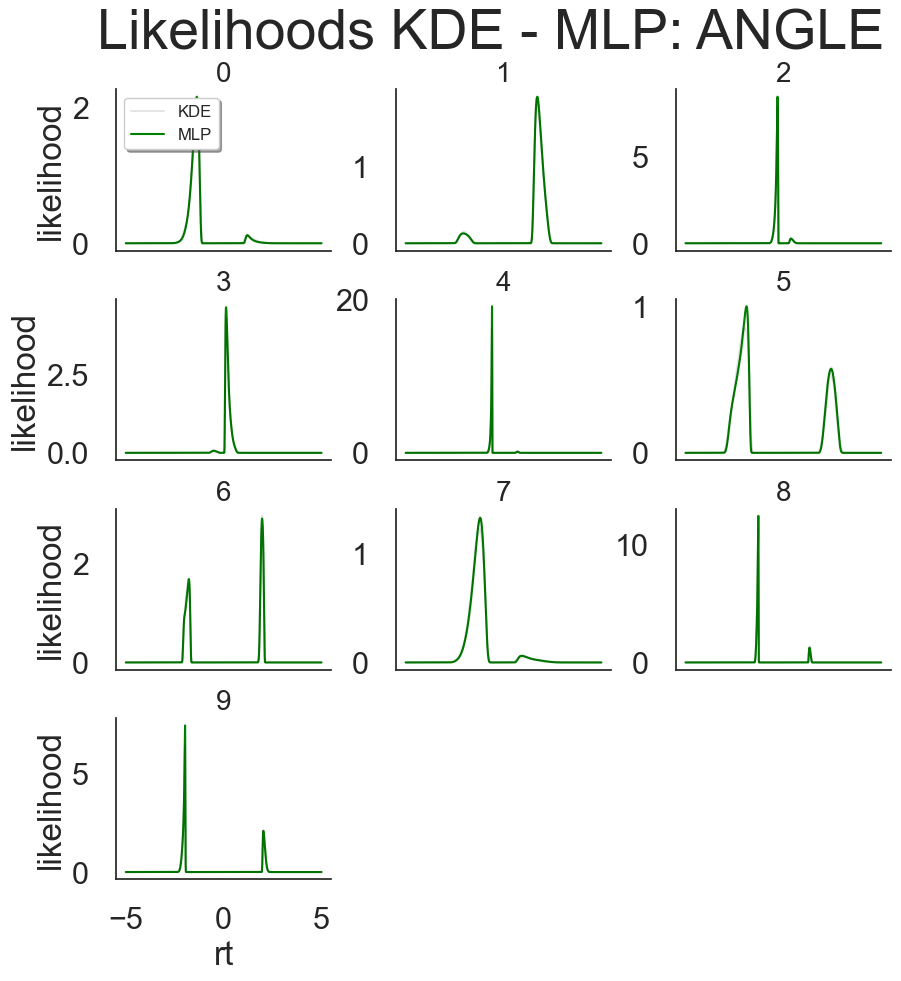

In [72]:
hddm.network_inspectors.kde_vs_lan_likelihoods(parameter_df = parameter_df, 
                                               model = model,
                                               cols = 3,
                                               n_samples = 2000,
                                               n_reps = 2,
                                               show = True)

#### 9.2.2 ```lan_manifold()```

Lastly, you can use the ```lan_manifold()``` plot to investigate the LAN likelihoods over a range of parameters. 

The idea is to use a base parameter vector and vary one of the parameters in a prespecificed range. 

This plot can be informative if you would like to understand better how a parameter affects model behavior.

#### 

In [73]:
# Make some parameters
parameter_df = hddm.simulators.make_parameter_vectors_nn(model = model,
                                                         param_dict = None,
                                                         n_parameter_vectors = 1)

In [74]:
parameter_df

v         a         z         t     theta
0  1.45342  1.454599  0.509081  0.156102 -0.039204

Using only the first row of the supplied parameter array !


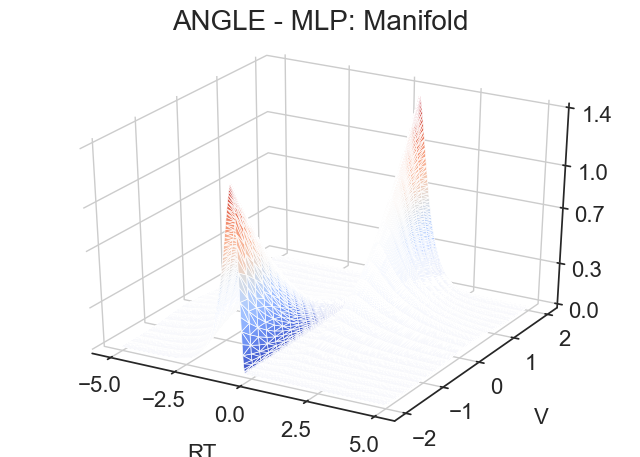

In [75]:
# Now plotting
hddm.network_inspectors.lan_manifold(parameter_df = parameter_df,
                                     vary_dict = {'v': np.linspace(-2, 2, 20)},
                                     model = model,
                                     n_rt_steps = 300,
                                     fig_scale = 1.0,
                                     max_rt = 5,
                                     save = True,
                                     show = True)

# END

Hopefully this tutorial proves as a useful starting point for your application.